# <center> Статистические тесты в контексте EDA

## Загрузка и обработка данных

In [174]:
# Импортируем необходимые нам библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# Игнорируем всплывающие предупрежедения 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

Данные были скопированы в Google Drive, они доступны по [ссылке](https://drive.google.com/file/d/1AJjCBpWZ9GnO8UGfDZxjmrGQjUlaB1Sj/view?usp=drive_link).

In [175]:
# Загружаем и читаем датасет
data = pd.read_csv('data/ds_salaries.csv', index_col=[0])
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [176]:
# Проеряем корректность типов данных столбцов и наличие в них пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В нашем датасете 607 записей (без пропущенных значений).

Проверим наши данные на наличие дубликатов:

In [177]:
print('Количество дубликатов в данных: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов в данных: 42


Удаляем найденные дубликаты

In [178]:
data = data.drop_duplicates()

Проверяем результат

In [179]:
print('Количество дубликатов в данных: {}'.format(data[data.duplicated()].shape[0]))
print(f'Результирующее число записей: {data.shape[0]}')

Количество дубликатов в данных: 0
Результирующее число записей: 565


Как мы можем видеть, теперь в наших данных нет пропущенных значений и дубликатов, все типы данных столбцов соответствуют их значениям.

Но в наших данных есть неинформативные признаки, которые не будут участвовать в нашем исследовании, такие как:

* *`salary`* —  в нашем датасете изначально имеется столбец *`salary_in_usd`* в котором все значения столбца *`salary`* приведены к единой валюте (*USD*). Для удобства, мы будем использовать именно его.

* *`salary_currency`* — необходимости в наименовании изначальной валюты у нас так же нет.

Удаляем все вышеперечисленные столбцы:

In [180]:
data = data.drop(['salary', 'salary_currency'], axis=1)

С анализом структуры наших данных и их корректности мы закончили, перейдём к их типам.

Обращаем внимание на столбцы *`experience_level`*, *`employment_type`*, *`remote_ratio`* и *`company_size`* которые ввиду своей структуры явно напрашиваются на приведение к типу данных *category*. Но как определить, какие ещё столбцы мы можем привести к типу *category*?

Создадим *DataFrame* *`unique_counts`* из структурированного массива, столбцами которого будут имена и количество уникальных значений в них из нашего изначального датасета *`data`*:

In [181]:
# from_records: создает объект DataFrame из структурированного массива
unique_counts = pd.DataFrame.from_records([(col, data[col].nunique()) for col in data.columns],
                                          columns=['Column_Name', 'Num_Unique']).sort_values(by='Num_Unique')

# Вызываем наш DataFrame
unique_counts

,Column_Name,Num_Unique
0,work_year,3
6,remote_ratio,3
8,company_size,3
1,experience_level,4
2,employment_type,4
3,job_title,50
7,company_location,50
5,employee_residence,57
4,salary_in_usd,369


Из увиденного, мы можем сделать следующие выводы:

* Во первых: мы можем смело приводить все наши столбцы за исключением *`work_year`* и *`salary_in_usd`* к типу данных *category*;

* Во вторых: в дополнительных корректировках нуждается столбец *`remote_ratio`* ведь изначально значения в нём имеют вид числа (*int64*);

* В третьих: столбцы *`company_location`* и *`employee_residence`* после приведения типов будут иметь слишком много категорий стран — это нужно будет исправить.

In [182]:
# Корректируем столбец remote_ratio
data['remote_ratio'] = data['remote_ratio'].apply(lambda x: 'No' if x == 0
                                                  else 'Partially' if x == 50
                                                  else 'Full')

In [183]:
# Корректируем столбец company_location — посмотрим на количество значений каждой страны
data['company_location'].value_counts()

company_location
US    318
GB     46
CA     28
DE     27
IN     24
FR     15
ES     14
GR     10
JP      6
NL      4
AT      4
PT      4
PL      4
LU      3
PK      3
BR      3
AE      3
MX      3
AU      3
TR      3
DK      3
IT      2
CZ      2
SI      2
RU      2
CH      2
NG      2
CN      2
BE      2
VN      1
EE      1
AS      1
DZ      1
MY      1
MD      1
KE      1
SG      1
CO      1
IR      1
CL      1
MT      1
IL      1
UA      1
IQ      1
RO      1
HR      1
NZ      1
HU      1
HN      1
IE      1
Name: count, dtype: int64

Как видим, категория `"US"` имеет более 50% значений, по сравнению с другими странами. А значит и сравнивать их между собой будет нецелесообразно.

Но мы всё же оставим данный признак для сравнения зарплат в `"US"` и остальных странах, которые мы пометим как `"Other"`.

In [184]:
# Корректируем столбец company_location — проверяем принадлежность страны к US, остальные отмечаем как Other
data['company_location'] = data['company_location'].apply(lambda x: x if x == 'US' else 'Other')

# Проверяем результат
data['company_location'].value_counts()

company_location
US       318
Other    247
Name: count, dtype: int64

In [185]:
# Корректируем столбец employee_residence — посмотрим на количество значений каждой страны
data['employee_residence'].value_counts()

employee_residence
US    295
GB     43
IN     30
CA     27
DE     24
FR     18
ES     15
GR     12
JP      7
PT      6
BR      6
PK      6
NL      5
PL      4
IT      4
RU      4
AE      3
AT      3
VN      3
TR      3
AU      3
RO      2
BE      2
SG      2
SI      2
DK      2
HU      2
NG      2
MX      2
BO      1
MY      1
TN      1
IE      1
DZ      1
AR      1
CZ      1
JE      1
LU      1
PR      1
RS      1
EE      1
CL      1
HK      1
KE      1
MD      1
CO      1
IR      1
CN      1
MT      1
UA      1
IQ      1
HN      1
BG      1
HR      1
PH      1
NZ      1
CH      1
Name: count, dtype: int64

Ситуация с данным признаком аналогична предыдущему. Следовательно, мы проведём те же манипуляции, что и с *`company_location`*.

In [186]:
data['employee_residence'] = data['employee_residence'].apply(lambda x: x if x == 'US' else 'Other')

data['employee_residence'].value_counts()

employee_residence
US       295
Other    270
Name: count, dtype: int64

Приступим к приведению типов:

In [187]:
# Задаём столбцы исключения
cols_to_exclude = ['work_year', 'salary_in_usd']

# Приводим столбцы к типу данных category
for col in data.columns:
    if col not in cols_to_exclude:
        data[col] = data[col].astype('category')

In [188]:
# Посмотрим на результаты
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           565 non-null    int64   
 1   experience_level    565 non-null    category
 2   employment_type     565 non-null    category
 3   job_title           565 non-null    category
 4   salary_in_usd       565 non-null    int64   
 5   employee_residence  565 non-null    category
 6   remote_ratio        565 non-null    category
 7   company_location    565 non-null    category
 8   company_size        565 non-null    category
dtypes: category(7), int64(2)
memory usage: 20.4 KB


Теперь, после всех вышеперечисленных корректировок над датасетом мы можем наконец-то посмотреть на сновные статистические характеристики каждого из признаков:

In [189]:
data.describe(include=['category', 'int64']).round()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.0,565,565,565,565.0,565,565,565,565
unique,NaN,4,4,50,NaN,2,3,2,3
top,NaN,SE,FT,Data Scientist,NaN,US,Full,US,M
freq,NaN,243,546,130,NaN,295,346,318,290
mean,2021.0,NaN,NaN,NaN,110610.0,NaN,NaN,NaN,NaN
std,1.0,NaN,NaN,NaN,72281.0,NaN,NaN,NaN,NaN
min,2020.0,NaN,NaN,NaN,2859.0,NaN,NaN,NaN,NaN
25%,2021.0,NaN,NaN,NaN,60757.0,NaN,NaN,NaN,NaN
50%,2021.0,NaN,NaN,NaN,100000.0,NaN,NaN,NaN,NaN
75%,2022.0,NaN,NaN,NaN,150000.0,NaN,NaN,NaN,NaN


Из статистической характеристики мы можем получить следующие сведения:

* *`experience_level`* — чаще всего встречающийся опыт работы среди сотрдников — *`SE` — Senior-level/Expert* (243 значения);

* *`employment_type`* — подавляющее большинство сотрудников трудоустраиваются на `полный рабочий день` (546 значений).
   
   Так как 96% всех значений у нас относятся к категории `FT`, мы избавимся от данного признака ввиду его неинформативности. Проводить статистические тесты на таком признаке нельзя;

* *`job_title`* — чаще всего роль, в которой соискатель работал в течение года — *`Data Scientist`* (130 значений);

* *`salary_in_usd`*:
  
  * Зарплата в долларах США имеет аномально большой разброс от минимального значения (2859$) к максимальному (600000$), что может являться выбросом в пользу наибольшего значения;

  * Так же стоит обратить внимание на стандартное отклонение в размере 72281$ от среднего (110610$) что может стать результатом выброса в данных, о чём сигнализирует максимальное значение признака;

  * Не стоит забывать и о том, что многие значения признака конвертированы в доллар США, из-за чего и может возникать такой разброс в данных;

  * Для подтверждения или опровержения наблюдений необходим дальнейший визуальный анализ данных.

* *`employee_residence`* — наиболее встречающаяся страна проживания сотрудника в течение рабочего года — `US` (295 значений);

* *`remote_ratio`* — общий объём работы, выполняемой удалённо у сотрудников более 80% (`Полностью удалённая работа` — 346 значений);

* *`company_location`* — страна главного офиса работодателя или филиала, как и в случае со страной проживания сотрудника — `US` (318 значений);

* *`company_size`* — чаще всего сотрудники работали в компаниях средних размеров — `M` (290 значений).

In [190]:
# Удаляем неинформативный признак
data = data.drop('employment_type', axis=1)

## Разведывательный анализ данных

Для наилучшего понимания того, что из себя представляют наши признаки и каковы их распределения, медианы и частоты значений мы их визуализируем.

### Визуальный анализ данных (распределение признаков)

#### Распределение признака года

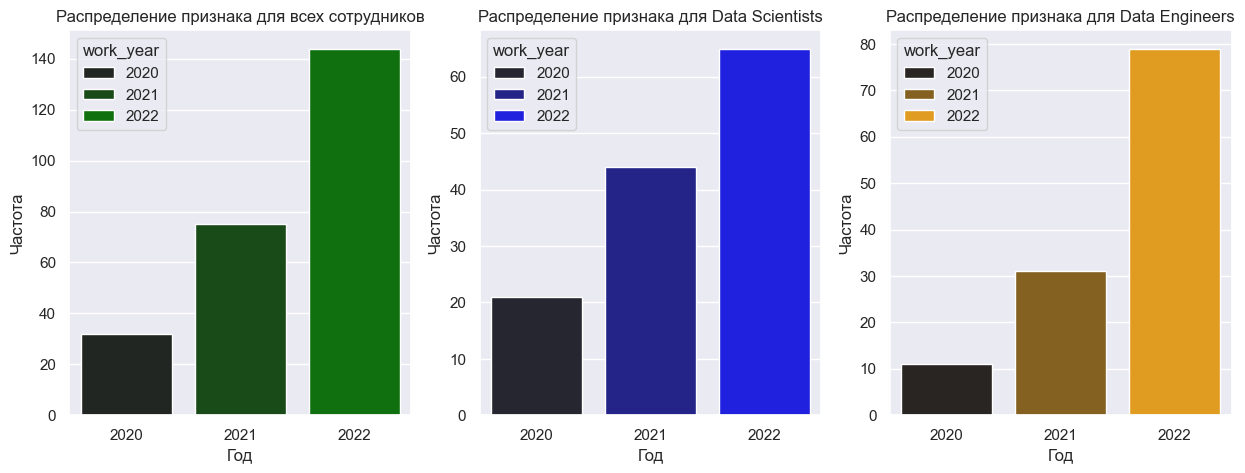

In [191]:
# DataFrame с годами и количеством их наблюдений для Data Scientists и Data Engineers 
work_year_distribution = data.loc[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer'), 'work_year'].value_counts().to_frame()

# DataFrame с годами и количеством их наблюдений для Data Scientists
ds_work_year_distribution = data.loc[data['job_title'] == 'Data Scientist', 'work_year'].value_counts().to_frame()

# DataFrame с годами и количеством их наблюдений для Data Engineers 
de_work_year_distribution = data.loc[data['job_title'] == 'Data Engineer', 'work_year'].value_counts().to_frame()

fig, axes = plt.subplots(1, 3, figsize=(15 ,5))

# Столбчатая диаграмма распределения признака для всех сотрудников
sns.barplot(
    data=work_year_distribution,
    x='work_year',
    y='count',
    hue='work_year',
    palette='dark:green',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Год', ylabel = 'Частота')
axes[0].set_title('Распределение признака для всех сотрудников')

# Столбчатая диаграмма распределения признака для Data Scientists
sns.barplot(
    data=ds_work_year_distribution,
    x='work_year',
    y='count',
    hue='work_year',
    palette='dark:blue',
    legend=True,
    ax=axes[1]
)
axes[1].set(xlabel='Год', ylabel = 'Частота')
axes[1].set_title('Распределение признака для Data Scientists')

# Столбчатая диаграмма распределения признака для Data Engineers
sns.barplot(
    data=de_work_year_distribution,
    x='work_year',
    y='count',
    hue='work_year',
    palette='dark:orange',
    legend=True,
    ax=axes[2]
)
axes[2].set(xlabel='Год', ylabel = 'Частота')
axes[2].set_title('Распределение признака для Data Engineers');

Вызовем наши таблицы распределений, чтобы узнать точное количество наблюдений для каждого года и специальности.

In [192]:
# Таблица распределения значений для Data Scientist и Data Engineer
work_year_distribution

,count
work_year,
2022,144
2021,75
2020,32


In [193]:
# Таблица распределения значений для Data Scientist
ds_work_year_distribution

,count
work_year,
2022,65
2021,44
2020,21


In [194]:
# Таблица распределения значений для Data Engineer
de_work_year_distribution

,count
work_year,
2022,79
2021,31
2020,11


**Выводы по графику**

* Как мы можем видеть, заметен резкий рост наблюдений для каждого из последующий годов как по отдельности, так и вместе.
  
  Такой рост (в некоторых случаях `более, чем в 2 раза!`) значений говорит о заинтересованности компаний в увеличении штата сотрудников *Data Scientists* и *Data Engineers* и росте популярности самих профессий, что наглядно демонстрируют нам наши графики.

#### Распределение признака опыт работы

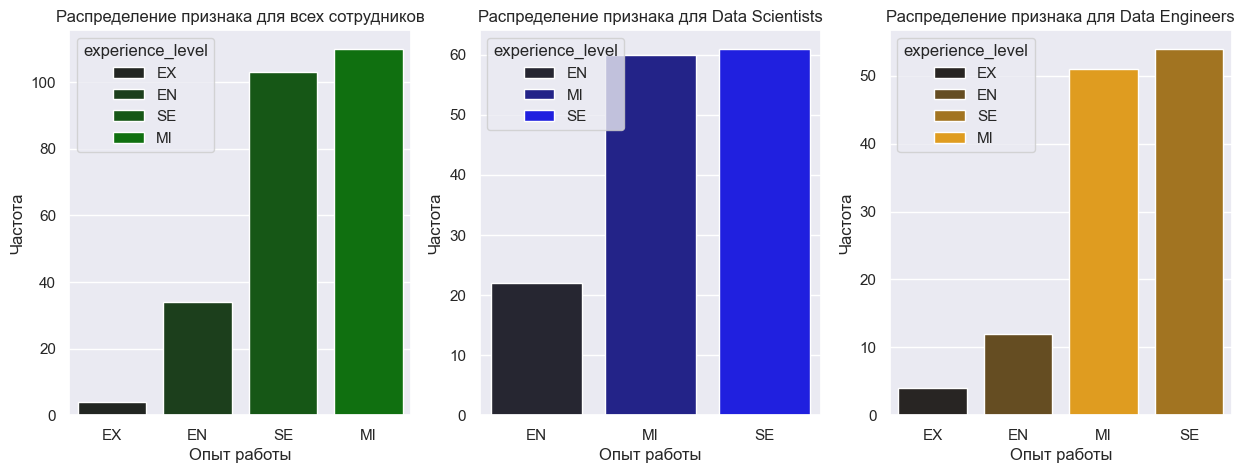

In [195]:
# Разгружаем память plt.figure и sns.barplot от предыдущих вводов
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Временный массив — наш оригинальный датасет (без видоизменений в 'Загрузка и обработка данных')
# Необходим для корректного создания всех последуюищих массивов при визуализации данных
temporary_df = pd.read_csv('data/ds_salaries.csv')

# DataFrame с наименованиями опыта работы и количеством их наблюдений для Data Scientists и Data Engineers 
experience_level_distribution = data.loc[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer'), 'experience_level'].value_counts().to_frame().sort_values('count')

# DataFrame с наименованиями опыта работы и количеством их наблюдений для Data Scientists
ds_experience_level_distribution = temporary_df.loc[temporary_df['job_title'] == 'Data Scientist', 'experience_level'].value_counts().to_frame().sort_values('count')

# DataFrame с наименованиями опыта работы и количеством их наблюдений для Data Engineers 
de_experience_level_distribution = data.loc[data['job_title'] == 'Data Engineer', 'experience_level'].value_counts().to_frame().sort_values('count')

fig, axes = plt.subplots(1, 3, figsize=(15 ,5))

# Столбчатая диаграмма распределения признака для всех сотрудников
sns.barplot(
    data=experience_level_distribution,
    x='experience_level',
    y='count',
    hue='experience_level',
    hue_order=experience_level_distribution['count'].index,
    order=experience_level_distribution['count'].index,
    palette='dark:green',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Опыт работы', ylabel = 'Частота')
axes[0].set_title('Распределение признака для всех сотрудников')

# Столбчатая диаграмма распределения признака для Data Scientists
sns.barplot(
    data=ds_experience_level_distribution,
    x='experience_level',
    y='count',
    hue='experience_level',
    palette='dark:blue',
    legend=True,
    ax=axes[1]
)
axes[1].set(xlabel='Опыт работы', ylabel = 'Частота')
axes[1].set_title('Распределение признака для Data Scientists')

# Столбчатая диаграмма распределения признака для Data Engineers
sns.barplot(
    data=de_experience_level_distribution,
    x='experience_level',
    y='count',
    hue='experience_level',
    hue_order=experience_level_distribution['count'].index,
    order=de_experience_level_distribution['count'].index,
    palette='dark:orange',
    legend=True,
    ax=axes[2]
)
axes[2].set(xlabel='Опыт работы', ylabel = 'Частота')
axes[2].set_title('Распределение признака для Data Engineers');

Вызовем наши таблицы распределений, чтобы узнать точное количество наблюдений для каждой категории опыта работы и специальности.

In [196]:
# Таблица распределения значений для Data Scientist и Data Engineer
experience_level_distribution

,count
experience_level,
EX,4
EN,34
SE,103
MI,110


In [197]:
# Таблица распределения значений для Data Scientist
ds_experience_level_distribution

,count
experience_level,
EN,22
MI,60
SE,61


In [198]:
# Таблица распределения значений для Data Engineer
de_experience_level_distribution

,count
experience_level,
EX,4
EN,12
MI,51
SE,54


**Выводы по графику**

* Из всех представленных категорий опыта работы, преобладающим является категория `SE` — *Senior-level/Expert*.

  Такое колличество наблюдений для более опытных сотрудников очевидно, ведь компании заинтересованы в найме более опытных специалистов, посльку они являются возможностью развития самой компании, а также наставниками для менее опытных специалистов.

* Так же стоит обратить внимание на отсутствие наблюдений для категории опыта работы `EX` — *Executive-level/Director* у *Data Scientist*. Необходимо учесть это при сравнении уровня оплаты труда специалистов *Data Scientist* и *Data Enggineer* в зависимости от опыта работы.

#### Распределение признака должность

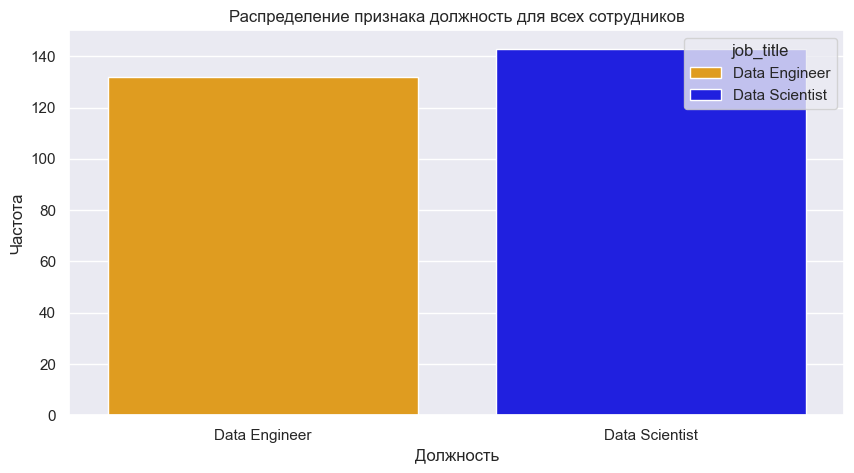

In [199]:
# DataFrame с наименованиями должностей и количеством их наблюдений для Data Scientists и Data Engineers 
job_title_distribution = temporary_df.loc[(temporary_df['job_title'] == 'Data Scientist') | (temporary_df['job_title'] == 'Data Engineer'), 'job_title'].value_counts(ascending=True).to_frame()

fig = plt.figure(figsize=(10, 5))

# Столбчатая диаграмма распределения признака для сотрудников Data Scientists и Data Engineers 
barplot = sns.barplot(
    data=job_title_distribution,
    x='job_title',
    y='count',
    hue='job_title',
    palette=['orange', 'blue'],
    legend=True
)
barplot.set_title('Распределение признака должность для всех сотрудников')
barplot.set_xlabel('Должность')
barplot.set_ylabel('Частота');

Вызовем нашу таблицу распределений, чтобы узнать точное количество наблюдений для каждой специальности.

In [200]:
# Таблица распределения значений для Data Scientist и Data Engineer
job_title_distribution

,count
job_title,
Data Engineer,132
Data Scientist,143


**Выводы по графику**

* Для целевых специальностей наблюдается небольшой перевес со стороны специалистов *Data Scientists* в количестве наблюдений (без разреза на отдельные категории). Это нужно учесть при проведедении последующих статистических тестов.

#### Распределение признака заработной платы

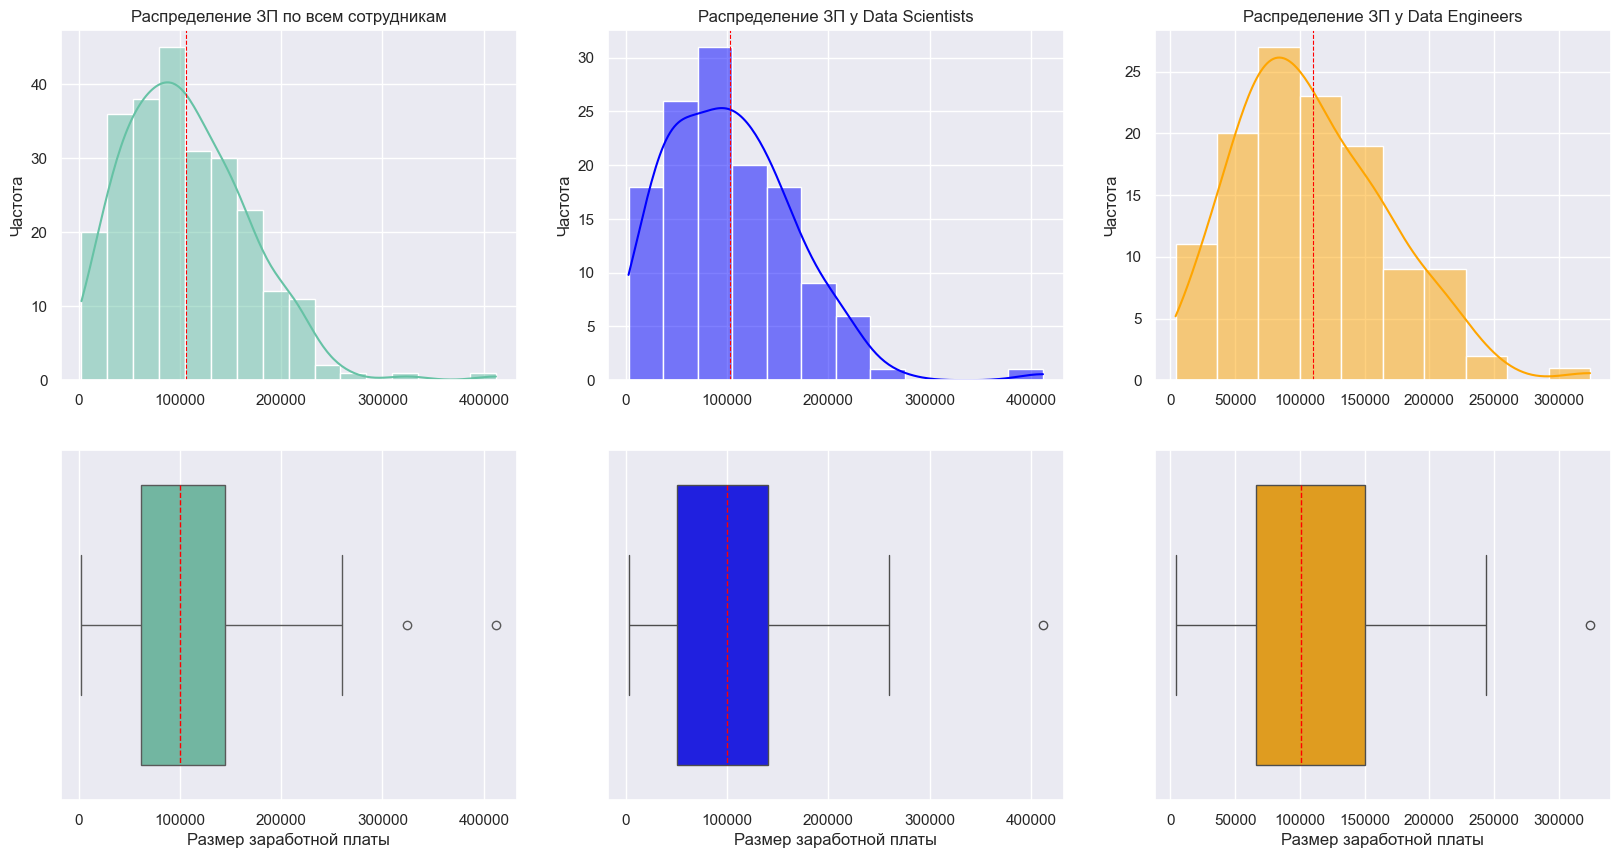

In [201]:
# DataFrame с заработной платой для Data Scientists и Data Engineers 
salary_in_usd_distribution = data.loc[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer'), 'salary_in_usd'].to_frame()

# DataFrame с заработной платой для Data Scientists
ds_salary_in_usd_distribution = data.loc[data['job_title'] == 'Data Scientist', 'salary_in_usd'].to_frame()

# DataFrame с заработной платой для Data Engineers 
de_salary_in_usd_distribution = data.loc[data['job_title'] == 'Data Engineer', 'salary_in_usd'].to_frame()

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Гистограмма распределения признака для всех сотрудников
sns.histplot(data=salary_in_usd_distribution['salary_in_usd'], kde=True, ax=axes[0, 0])
axes[0, 0].set(xlabel = '', ylabel = 'Частота')
axes[0, 0].set_title('Распределение ЗП по всем сотрудникам')
axes[0, 0].axvline(salary_in_usd_distribution['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

# Гистограмма распределения признака для Data Scientists
sns.histplot(data=ds_salary_in_usd_distribution['salary_in_usd'], kde=True, ax=axes[0, 1], color='blue')
axes[0, 1].set(xlabel = '', ylabel = 'Частота')
axes[0, 1].set_title('Распределение ЗП у Data Scientists')
axes[0, 1].axvline(ds_salary_in_usd_distribution['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

# Гистограмма распределения признака для Data Engineers
sns.histplot(data=de_salary_in_usd_distribution['salary_in_usd'], kde=True, ax=axes[0, 2], color='orange')
axes[0, 2].set(xlabel = '', ylabel = 'Частота')
axes[0, 2].set_title('Распределение ЗП у Data Engineers')
axes[0, 2].axvline(de_salary_in_usd_distribution['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

# Коробчатая диаграмма распределения признака для всех сотрудников
sns.boxplot(data=salary_in_usd_distribution['salary_in_usd'], ax=axes[1, 0], orient='h', medianprops={'color': 'red', 'linestyle': '--'})
axes[1, 0].set(xlabel='Размер заработной платы')

# Коробчатая диаграмма распределения признака для Data Scientists
sns.boxplot(data=ds_salary_in_usd_distribution['salary_in_usd'], ax=axes[1, 1], orient='h', color='blue', medianprops={'color': 'red', 'linestyle': '--'})
axes[1, 1].set(xlabel='Размер заработной платы')

# Коробчатая диаграмма распределения признака для Data Engineers
sns.boxplot(data=de_salary_in_usd_distribution['salary_in_usd'], ax=axes[1, 2], orient='h', color='orange', medianprops={'color': 'red', 'linestyle': '--'})
axes[1, 2].set(xlabel='Размер заработной платы');

Выведем основную статистическую характеристику заработной платы для каждой специальности по отдельности и вместе. 

In [202]:
# Основная статистическая характеристика для Data Scientist и Data Engineer
salary_in_usd_distribution.describe().round()

,salary_in_usd
count,251.0
mean,106428.0
std,61219.0
min,2859.0
25%,62096.0
50%,100000.0
75%,144500.0
max,412000.0


In [203]:
# Основная статистическая характеристика для Data Scientist
ds_salary_in_usd_distribution.describe().round()

,salary_in_usd
count,130.0
mean,103336.0
std,63968.0
min,2859.0
25%,50330.0
50%,100000.0
75%,140400.0
max,412000.0


In [204]:
# Основная статистическая характеристика для Data Engineer
de_salary_in_usd_distribution.describe().round()

,salary_in_usd
count,121.0
mean,109750.0
std,58204.0
min,4000.0
25%,66022.0
50%,100800.0
75%,150000.0
max,324000.0


**Выводы по графику**

* Признак `'salary_in_usd'` — зарплата в долларах США не распределён нормально, имеются выбросы как у *Data Scientist* (412000 *USD*), так и у *Data Engineer* (324000 *USD*).

* На первый взгляд кажется, что у специалистов *Data Engineer* заработная плата выше, чем у *Data Scientist*. Но так же стоит учитывать и то, что количество наблюдений для *Data Engineers* меньше, чем у *Data Scientists*, что так же сказывается и на статистической характеристике признака. Мы не можем быть до конца уверены в том, что распределения не отличались бы при достаточном количестве наблюдений для каждой из специальностей.

* Так как выбросы искажают среднее значение заработной платы, в дальнейшем при изучении признаков в разрезе по категориям мы будем ссылаться на медианное значение.

#### Распределение признака страны проживания сотрудника в течении рабочего года

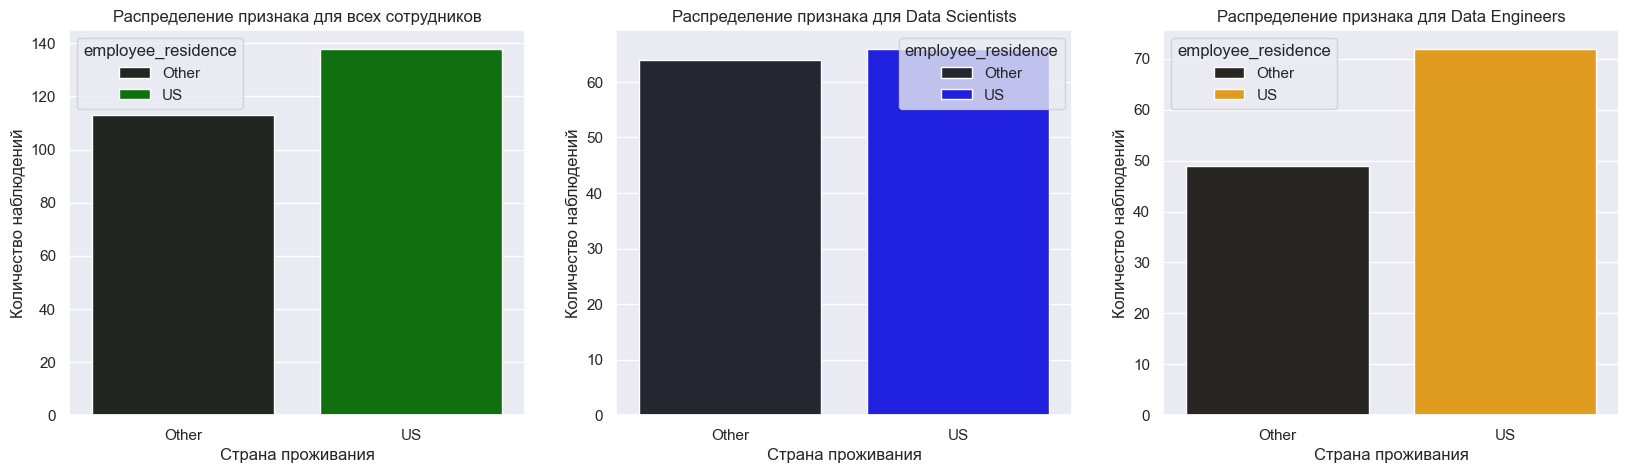

In [205]:
# DataFrame с наименованиями стран и их количеством наблюдений для Data Scientists и Data Engineers 
employee_residence_distribution = data.loc[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer'), 'employee_residence'].value_counts().to_frame()

# DataFrame с наименованиями стран и их количеством наблюдений для Data Scientists
ds_employee_residence_distribution = data.loc[data['job_title'] == 'Data Scientist', 'employee_residence'].value_counts().to_frame()

# DataFrame с наименованиями стран и их количеством наблюдений для Data Engineers
de_employee_residence_distribution = data.loc[data['job_title'] == 'Data Engineer', 'employee_residence'].value_counts().to_frame()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Столбчатая диаграмма распределения признака для всех сотрудников
sns.barplot(
    data=employee_residence_distribution,
    x='employee_residence',
    y='count',
    hue='employee_residence',
    palette='dark:green',
    legend=True,
    ax=axes[0]
)
axes[0].set_title('Распределение признака для всех сотрудников')
axes[0].set_xlabel('Страна проживания')
axes[0].set_ylabel('Количество наблюдений')

# Столбчатая диаграмма распределения признака для Data Scientists
sns.barplot(
    data=ds_employee_residence_distribution,
    x='employee_residence',
    y='count',
    hue='employee_residence',
    palette='dark:blue',
    legend=True,
    ax=axes[1]
)
axes[1].set_title('Распределение признака для Data Scientists')
axes[1].set_xlabel('Страна проживания')
axes[1].set_ylabel('Количество наблюдений')

sns.barplot(
    data=de_employee_residence_distribution,
    x='employee_residence',
    y='count',
    hue='employee_residence',
    palette='dark:orange',
    legend=True,
    ax=axes[2]
)
axes[2].set_title('Распределение признака для Data Engineers')
axes[2].set_xlabel('Страна проживания')
axes[2].set_ylabel('Количество наблюдений');

Вызовем наши таблицы распределений, чтобы узнать более точное количество наблюдений для каждой категории признака у сотрудников.

In [206]:
# Таблица распределения значений для Data Scientist и Data Engineer
employee_residence_distribution

,count
employee_residence,
US,138
Other,113


In [207]:
# Таблица распределения значений для Data Scientist
ds_employee_residence_distribution

,count
employee_residence,
US,66
Other,64


In [208]:
# Таблица распределения значений для Data Engineer
de_employee_residence_distribution

,count
employee_residence,
US,72
Other,49


**Выводы по графику**

* Как мы можем заметить, не смотря на то, что мы объединили все страны кроме `US` (США) в одну единую группу — `Other`, самой популярной страной для проживания в течении рабочего года у целевых сотрудников вместе, и по отдельности были именно Соединенные Штаты (категория `US`).

  Такая популярность данной категории среди прочих 56 стран могла быть вызвана более высоким уровнем оплаты труда специалистов. Выяснить мы это сможет при детальном анализе взаимосвязи заработной платы и участвующих в нашем анализе признаков.

#### Распределение признака объёма работы, выполняемой удалённо у сотрудников

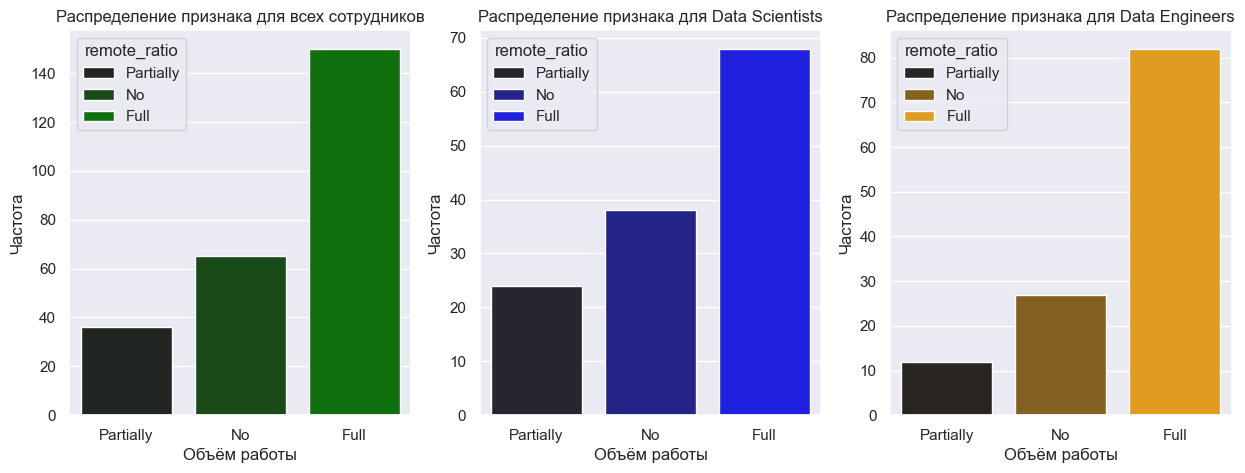

In [209]:
# DataFrame с наименованиями категорий объёма работы, выполняемой удалённо и их количеством наблюдений для Data Scientists и Data Engineers 
remote_ratio_distribution = data.loc[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer'), 'remote_ratio'].value_counts().to_frame().sort_values('count')

# DataFrame с наименованиями категорий объёма работы, выполняемой удалённо и их количеством наблюдений для Data Scientists 
ds_remote_ratio_distribution = data.loc[data['job_title'] == 'Data Scientist', 'remote_ratio'].value_counts().to_frame().sort_values('count')

# DataFrame с наименованиями категорий объёма работы, выполняемой удалённо и их количеством наблюдений для Data Engineers 
de_remote_ratio_distribution = data.loc[data['job_title'] == 'Data Engineer', 'remote_ratio'].value_counts().to_frame().sort_values('count')

fig, axes = plt.subplots(1, 3, figsize=(15 ,5))

# Столбчатая диаграмма распределения признака для всех сотрудников
sns.barplot(
    data=remote_ratio_distribution,
    x='remote_ratio',
    y='count',
    hue='remote_ratio',
    hue_order=remote_ratio_distribution['count'].index,
    order=remote_ratio_distribution['count'].index,
    palette='dark:green',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Объём работы', ylabel = 'Частота')
axes[0].set_title('Распределение признака для всех сотрудников')

# Столбчатая диаграмма распределения признака для Data Scientists
sns.barplot(
    data=ds_remote_ratio_distribution,
    x='remote_ratio',
    y='count',
    hue='remote_ratio',
    hue_order=remote_ratio_distribution['count'].index,
    order=ds_remote_ratio_distribution['count'].index,
    palette='dark:blue',
    legend=True,
    ax=axes[1]
)
axes[1].set(xlabel='Объём работы', ylabel = 'Частота')
axes[1].set_title('Распределение признака для Data Scientists')

# Столбчатая диаграмма распределения признака для Data Engineers
sns.barplot(
    data=de_remote_ratio_distribution,
    x='remote_ratio',
    y='count',
    hue='remote_ratio',
    hue_order=remote_ratio_distribution['count'].index,
    order=de_remote_ratio_distribution['count'].index,
    palette='dark:orange',
    legend=True,
    ax=axes[2]
)
axes[2].set(xlabel='Объём работы', ylabel = 'Частота')
axes[2].set_title('Распределение признака для Data Engineers');

Вызовем наши таблицы распределений, чтобы узнать более точное количество наблюдений для каждой категории признака у сотрудников.

In [210]:
# Таблица распределения значений для Data Scientist и Data Engineer
remote_ratio_distribution

,count
remote_ratio,
Partially,36
No,65
Full,150


In [211]:
# Таблица распределения значений для Data Scientist
ds_remote_ratio_distribution

,count
remote_ratio,
Partially,24
No,38
Full,68


In [212]:
# Таблица распределения значений для Data Engineer
de_remote_ratio_distribution

,count
remote_ratio,
Partially,12
No,27
Full,82


**Выводы по графику**

* Из всех представленных категорий, преобладающей является категория `Full` — полностью удалённая работа.

* Преобладание количества наблюдений по сравнению с другими категориями вероятнеее всего вызван периодом *COVID*-19, вследствии чего всем компаниям было попросту необходимо перейти на удалённый формат, для поддержания продуктивности сотрудников при работе. Так же отсутствие необходимости тратить время на дорогу до офиса, позволяет сотрудникам больше сосредоточиться на работе.

#### Распределение признака страны главного офиса работодателя или филиала

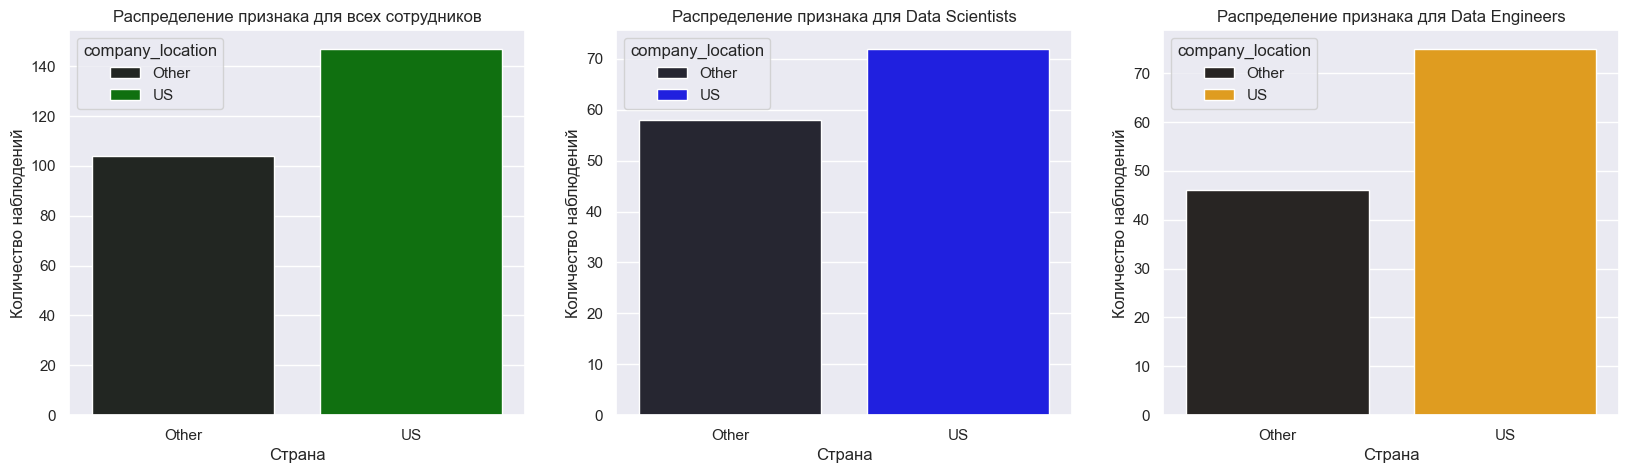

In [213]:
# DataFrame с наименованиями стран и их количеством наблюдений для Data Scientists и Data Engineers 
company_location_distribution = data.loc[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer'), 'company_location'].value_counts().to_frame()

# DataFrame с наименованиями стран и их количеством наблюдений для Data Scientists
ds_company_location_distribution = data.loc[data['job_title'] == 'Data Scientist', 'company_location'].value_counts().to_frame()

# DataFrame с наименованиями стран и их количеством наблюдений для Data Engineers
de_company_location_distribution = data.loc[data['job_title'] == 'Data Engineer', 'company_location'].value_counts().to_frame()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.barplot(
    data=company_location_distribution,
    x='company_location',
    y='count',
    hue='company_location',
    palette='dark:green',
    legend=True, 
    ax=axes[0]
)
axes[0].set_title('Распределение признака для всех сотрудников')
axes[0].set_xlabel('Страна')
axes[0].set_ylabel('Количество наблюдений')

sns.barplot(
    data=ds_company_location_distribution,
    x='company_location',
    y='count',
    hue='company_location',
    palette='dark:blue',
    legend=True,
    ax=axes[1]
)
axes[1].set_title('Распределение признака для Data Scientists')
axes[1].set_xlabel('Страна')
axes[1].set_ylabel('Количество наблюдений')

sns.barplot(
    data=de_company_location_distribution,
    x='company_location',
    y='count',
    hue='company_location',
    palette='dark:orange',
    legend=True,
    ax=axes[2]
)
axes[2].set_title('Распределение признака для Data Engineers')
axes[2].set_xlabel('Страна')
axes[2].set_ylabel('Количество наблюдений');

Вызовем наши таблицы распределений, чтобы узнать более точное количество наблюдений для каждой категории признака у сотрудников.

In [214]:
# Таблица распределения значений для Data Scientist и Data Engineer
company_location_distribution

,count
company_location,
US,147
Other,104


In [215]:
# Таблица распределения значений для Data Scientist
ds_company_location_distribution

,count
company_location,
US,72
Other,58


In [216]:
# Таблица распределения значений для Data Engineer
de_company_location_distribution

,count
company_location,
US,75
Other,46


**Выводы по графику**

* Как и в случае с признаком `'employee_residence'` категория `US` снова имеет большее количество записей, чем остальные страны из группы `Other`, что делает её так же и самой популярной страной нахождения компаний и их филиалов.

  Неудивительно, что именно США (категория `US`) находятся в лидирующих позициях по сравнению с остальными 49 странами имеющихся у нас изначально, ведь ни для кого не секрет, что в Америке очень сильное высшее образование. Большинство ученых, специалистов и просто выпускников сегодня, как и 50 лет назад, будет гораздо проще трудоустроить сразу же в родной для них стране, чем обременять их стрессом переезда, что подалкивает новые компании открывать свой бизнес, а крупные корпорации новые филиалы именно в Штатах.

* Если обратить внимание на количество записей для категорий признака, станет заметно, что они схожи с теми, что мы видели при визуализации распределения признака `'employee_residence'`. Это означает, что большинство сотрудников проживают в тех же странах, что и находятся офисы или филиалы компаний, в которых они работают.

#### Распределение признака размера компании

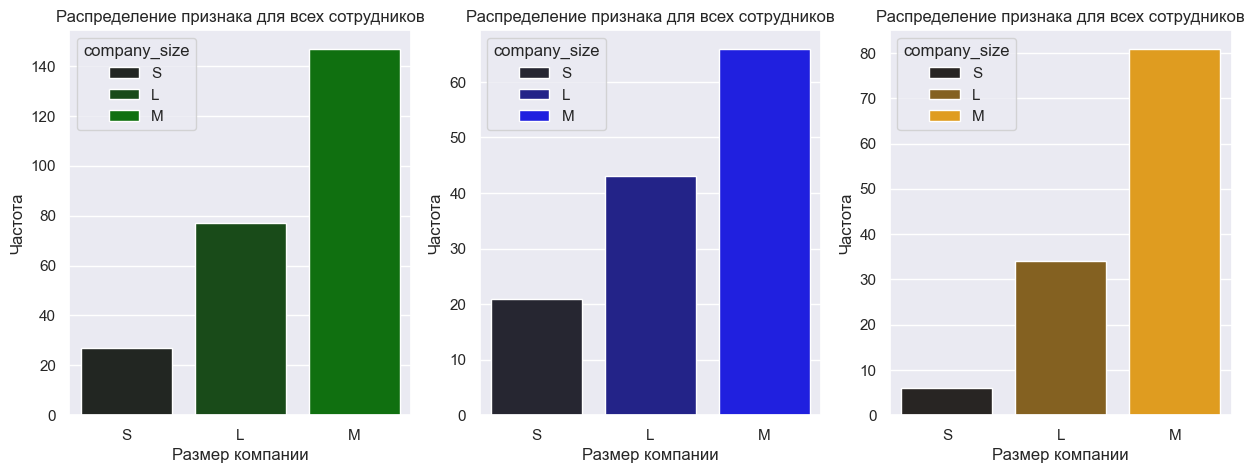

In [217]:
# DataFrame с наименованиями категорий размеров компаний и их количеством наблюдений для Data Scientists и Data Engineers 
company_size_distribution = data.loc[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer'), 'company_size'].value_counts().to_frame().sort_values('count')

# DataFrame с наименованиями категорий размеров компаний и их количеством наблюдений для Data Scientists
ds_company_size_distribution = data.loc[data['job_title'] == 'Data Scientist', 'company_size'].value_counts().to_frame().sort_values('count')

# DataFrame с наименованиями категорий размеров компаний и их количеством наблюдений для Data Engineers 
de_company_size_distribution = data.loc[data['job_title'] == 'Data Engineer', 'company_size'].value_counts().to_frame().sort_values('count')

fig, axes = plt.subplots(1, 3, figsize=(15 ,5))

# Столбчатая диаграмма распределения признака для всех сотрудников
sns.barplot(
    data=company_size_distribution,
    x='company_size',
    y='count',
    hue='company_size',
    hue_order=company_size_distribution['count'].index,
    order=company_size_distribution['count'].index,
    palette='dark:green',
    legend=True,
    ax = axes[0]
)
axes[0].set(xlabel='Размер компании', ylabel = 'Частота')
axes[0].set_title('Распределение признака для всех сотрудников')

# Столбчатая диаграмма распределения признака для Data Scientists
sns.barplot(
    data=ds_company_size_distribution,
    x='company_size',
    y='count',
    hue='company_size',
    hue_order=company_size_distribution['count'].index,
    order=ds_company_size_distribution['count'].index,
    palette='dark:blue',
    legend=True,
    ax = axes[1]
)
axes[1].set(xlabel='Размер компании', ylabel = 'Частота')
axes[1].set_title('Распределение признака для всех сотрудников')

# Столбчатая диаграмма распределения признака для Data Engineers
sns.barplot(
    data=de_company_size_distribution,
    x='company_size',
    y='count',
    hue='company_size',
    hue_order=company_size_distribution['count'].index,
    order=de_company_size_distribution['count'].index,
    palette='dark:orange',
    legend=True,
    ax = axes[2]
)
axes[2].set(xlabel='Размер компании', ylabel = 'Частота')
axes[2].set_title('Распределение признака для всех сотрудников');

Вызовем наши таблицы распределений, чтобы узнать более точное количество наблюдений для каждой категории признака у сотрудников.

In [218]:
# Таблица распределения значений для Data Scientist и Data Engineer
company_size_distribution

,count
company_size,
S,27
L,77
M,147


In [219]:
# Таблица распределения значений для Data Scientist
ds_company_size_distribution

,count
company_size,
S,21
L,43
M,66


In [220]:
# Таблица распределения значений для Data Engineer
de_company_size_distribution

,count
company_size,
S,6
L,34
M,81


**Выводы по графику**

* Как мы выяснили на этапе `Загрузка и обработка данных`, чаще всего сотрудники работали в компаниях средних размеров — категория `M`. Сейчас же мы можем наглядно наблюдать насколько она превосходит остальные категории.

  Её главенство над остальными категориями может быть вызвано следующими факторами:
  
   * Более достижимая возможность сделать карьеру. Движение по карьерной лестнице может проходит довольно быстро, с меньшей конкуренцией. Если же говорить про большие корпорации, то там двигаться по карьерной лестнице будет, скорее всего, несравненно сложнее.
  
   * Зачастую более теплая обстановка в коллективе, что может быть близкая к семейной. Для сотрдников, что очень волнует «климат» в коллективе на будущей работе, этот пункт тоже будет являться ключевым при выборе работодателя.

### Какие факторы влияют на зарплату специалиста *Data Scientist*? 

#### Заработная плата в зависимости от опыта работы у *Data Scientists*

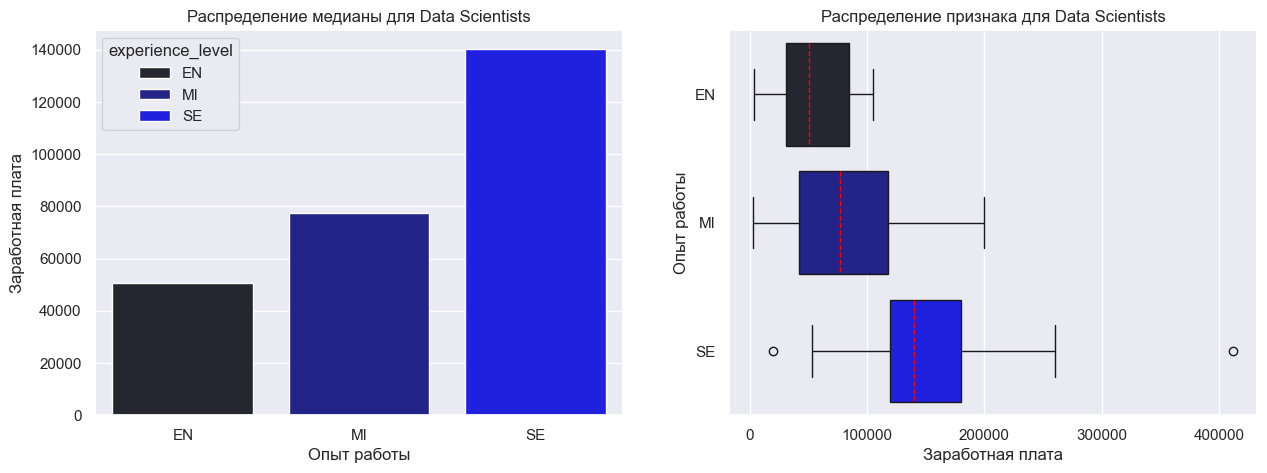

In [221]:
# Информация об заработных палатах специалистов Data Scienctists
ds_salaries_based_on_work_experience = temporary_df.loc[temporary_df['job_title'] == 'Data Scientist'].sort_values('experience_level')

# Группируем зарплаты специалистов Data Scienctists по опыту работы и находим их медианное значение
median_ds_salaries_based_on_work_experience = ds_salaries_based_on_work_experience.groupby('experience_level', as_index=False)['salary_in_usd'].median()

fig, axes = plt.subplots(1, 2, figsize=(15 ,5))

# Столбчатая диаграмма зависимости медианы признака от опыта работы для Data Scientists
sns.barplot(
    data=median_ds_salaries_based_on_work_experience,
    x='experience_level',
    y='salary_in_usd',
    hue='experience_level',
    palette='dark:blue',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Опыт работы', ylabel = 'Заработная плата')
axes[0].set_title('Распределение медианы для Data Scientists')

# Коробчатая диаграмма распределения признака по опыту работы для Data Scientists
sns.boxplot(
    data=ds_salaries_based_on_work_experience,
    x='salary_in_usd',
    y='experience_level',
    orient='h',
    palette='dark:blue',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel = 'Опыт работы')
axes[1].set_title('Распределение признака для Data Scientists');

Выведем основную статистическую характеристику заработной платы для каждого опыта работы. 

In [222]:
# Основная статистическая характеристика признака заработной платы для Data Scientists в разрезе опыта работы
ds_salaries_based_on_work_experience.groupby('experience_level')['salary_in_usd'].describe().round()

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55331.0,31238.0,4000.0,31474.0,50484.0,85027.0,105000.0
MI,60.0,82039.0,46870.0,2859.0,41768.0,77479.0,118265.0,200000.0
SE,61.0,152971.0,58985.0,20171.0,120000.0,140400.0,180000.0,412000.0


**Выводы по графику**

* На первый взгляд значения оплаты труда специалистов *Data Science* прямо пропорционально зависят от признака `'experience_level'` — опыта работы. Заметно, насколько сильно различны медианные значения и распределения признака от опыта работы.

  Чтобы определить, являются ли эти различия действительно статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

* Также мы теперь знаем, к какой группе опыта работы относятся наши выбросы в значениях заработной платы — категория `SE` (*Senior-level/Expert*), что говорит нам о том, что для остальных групп распределение является нормальным.

#### Заработная плата в зависимости от страны проживания сотрудника в течении рабочего года у *Data Scientists*

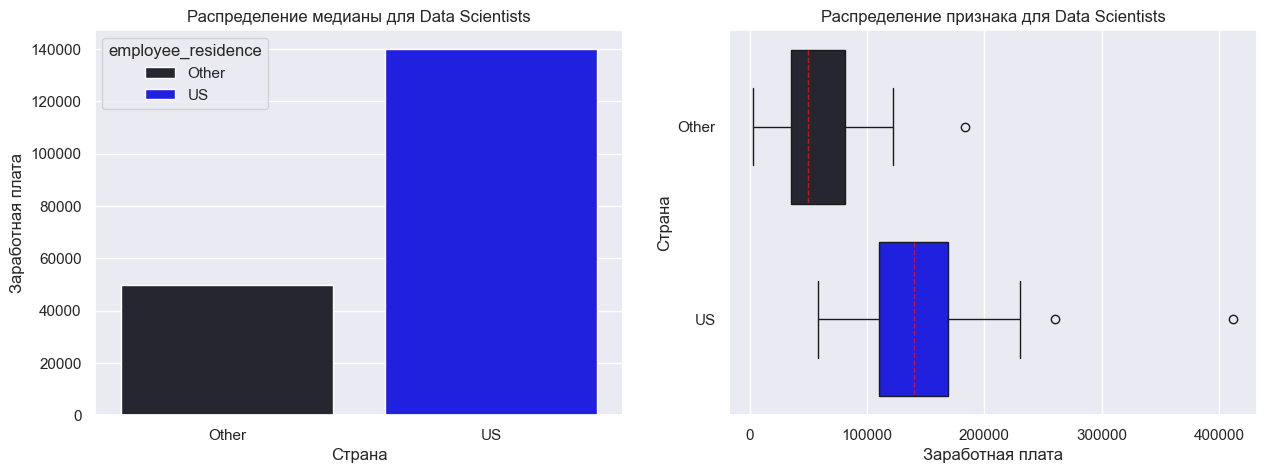

In [223]:
# Массив данных с информацией о сотрудниках Data Science
data_ds = data.loc[data['job_title'] == 'Data Scientist']

# Группируем зарплаты специалистов Data Science по стране проживания в течении рабочего года и находим их медианное значение
ds_salaries_based_on_country_of_residence = data_ds.groupby('employee_residence', as_index=False)['salary_in_usd'].median()

fig, axes = plt.subplots(1, 2, figsize=(15 ,5))

# Столбчатая диаграмма зависимости медианы признака от страны проживания для Data Scientists
sns.barplot(
    data=ds_salaries_based_on_country_of_residence,
    x='employee_residence',
    y='salary_in_usd',
    hue='employee_residence',
    palette='dark:blue',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Страна', ylabel = 'Заработная плата')
axes[0].set_title('Распределение медианы для Data Scientists')

# Коробчатая диаграмма распределения признака по стране проживания для Data Scientists
sns.boxplot(
    data_ds,
    x='salary_in_usd',
    y='employee_residence',
    orient='h',
    palette='dark:blue',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel = 'Страна')
axes[1].set_title('Распределение признака для Data Scientists');

Выведем основную статистическую характеристику заработной платы для каждой категории стран. 

In [224]:
# Основная статистическая характеристика признака заработной платы для Data Scientists в разрезе страны проживания
data_ds.groupby('employee_residence')['salary_in_usd'].describe().round()

,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
Other,64.0,58223.0,35238.0,2859.0,35699.0,49823.0,81550.0,183228.0
US,66.0,147083.0,54499.0,58000.0,110500.0,140200.0,169250.0,412000.0


**Выводы по графику**

* На первый взгляд распределения заработных плат и их медианных значений в зависимости от страны проживания сотрудника различны для каждой из категорий. Мы можем наглядно наблюдать, насколько зарплаты в `US` — США превосходят зарплаты в странах, что мы отметили как `Other` даже не смотря на то, что мы сравниваем единственную страну (США) с группой из 56 стран!

* Для каждой из категорий стран заметны выбросы в значениях уровня оплаты труда, нужно учитывать это при проведении статистических тестов над группами, которые необходимы для того, чтобы выяснить — являются ли эти различичя статистически значимыми.

#### Заработная плата в зависимости от общего объёма работы, выполняемой удалённо у *Data Scientists*

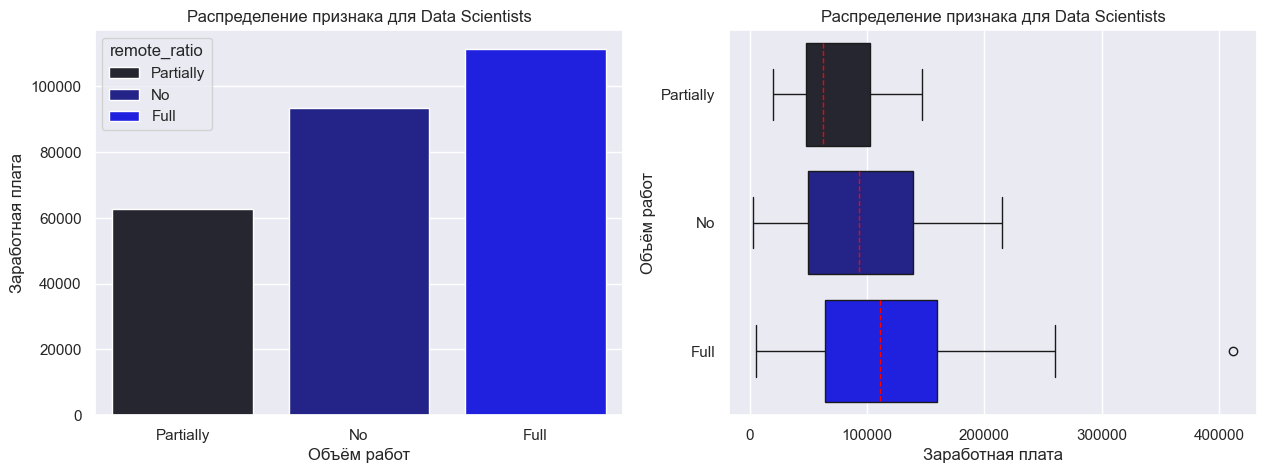

In [225]:
# Группируем зарплаты специалистов Data Science по объёму работы, выполняемой удалённо и находим их медианное значение
median_ds_salaries_based_on_remote_ratio = data_ds.groupby('remote_ratio', as_index=False)['salary_in_usd'].median().sort_values('salary_in_usd')

fig, axes = plt.subplots(1, 2, figsize=(15 ,5))

# Столбчатая диаграмма зависимости медианы признака от объёма работы, выполняемой удалённо для Data Scientists
barplot = sns.barplot(
    data=median_ds_salaries_based_on_remote_ratio,
    x='remote_ratio',
    y='salary_in_usd',
    hue='remote_ratio',
    hue_order=median_ds_salaries_based_on_remote_ratio['remote_ratio'],
    order=median_ds_salaries_based_on_remote_ratio['remote_ratio'],
    palette='dark:blue',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Объём работ', ylabel = 'Заработная плата')
axes[0].set_title('Распределение признака для Data Scientists')

# Коробчатая диаграмма распределения признака по объёму работы, выполняемой удалённо для Data Scientists
sns.boxplot(
    data_ds,
    x='salary_in_usd',
    y='remote_ratio',
    hue='remote_ratio',
    hue_order=median_ds_salaries_based_on_remote_ratio['remote_ratio'],
    order=median_ds_salaries_based_on_remote_ratio['remote_ratio'],
    orient='h',
    palette='dark:blue',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel = 'Объём работ')
axes[1].set_title('Распределение признака для Data Scientists');

Выведем основную статистическую характеристику заработной платы для каждой категории объёма работы, выполняемого специалистами удалённо. 

In [226]:
# Основная статистическая характеристика признака заработной платы для Data Scientists в разрезе объёма работы, выполняемой удалённо
data_ds.groupby('remote_ratio')['salary_in_usd'].describe().round()

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
Full,68.0,116485.0,70908.0,5679.0,64420.0,111500.0,160000.0,412000.0
No,38.0,98445.0,58648.0,2859.0,49781.0,93582.0,139050.0,215300.0
Partially,24.0,73828.0,36204.0,20171.0,47784.0,62726.0,102250.0,147000.0


**Выводы по графику**

* Распределения заработной платы их их медиан в зависимости от общего объёма работы, выполняемой удалённо различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты над группами.

* Помимо этого, стоит обратить внимание на выброс в группе `Full` — полностью удалённая работа. Его наличие может повлиять на то, какой статистический тест над нашими категориями стоит выбрать.

  Для остальных же групп распределения являются нормальными.

#### Заработная плата в зависимости от страны главного офиса работодателя или филиала у *Data Scientists*

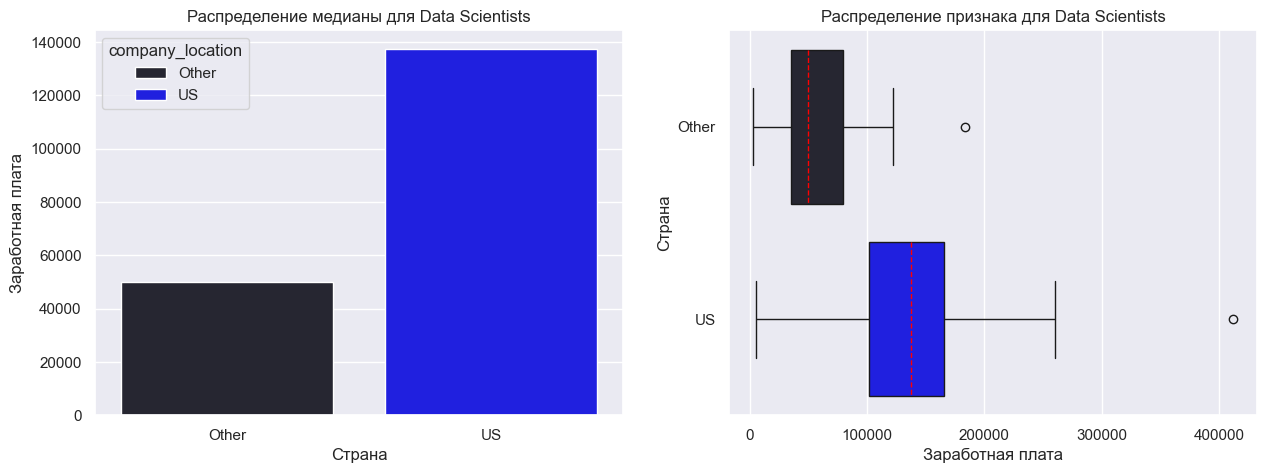

In [227]:
# Группируем зарплаты специалистов Data Science по стране главного офиса работодателя или филиала и находим их медианное значение
ds_salaries_based_on_company_location = data_ds.groupby('company_location', as_index=False)['salary_in_usd'].median()

fig, axes = plt.subplots(1, 2, figsize=(15 ,5))

# Столбчатая диаграмма зависимости медианы признака от страны главного офиса работодателя или филиала для Data Scientists
sns.barplot(
    data=ds_salaries_based_on_company_location,
    x='company_location',
    y='salary_in_usd',
    hue='company_location',
    palette='dark:blue',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Страна', ylabel = 'Заработная плата')
axes[0].set_title('Распределение медианы для Data Scientists')

# Коробчатая диаграмма распределения признака по стране главного офиса работодателя или филиала для Data Scientists
sns.boxplot(
    data_ds,
    x='salary_in_usd',
    y='company_location',
    orient='h',
    palette='dark:blue',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel = 'Страна')
axes[1].set_title('Распределение признака для Data Scientists');

Выведем основную статистическую характеристику заработной платы для каждой категории стран нахождения главного офиса или филиала компании. 

In [228]:
# Основная статистическая характеристика признака заработной платы для Data Scientists в разрезе страны главного офиса работодателя или филиала
data_ds.groupby('company_location')['salary_in_usd'].describe().round()

,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
Other,58.0,57904.0,35443.0,2859.0,35626.0,49823.0,79296.0,183228.0
US,72.0,139935.0,58150.0,5679.0,101575.0,137485.0,165665.0,412000.0


**Выводы по графику**

* Сразу бросаются в глаза сами медианы и распределения — они сильно (но не абсолютно) схожи с теми, что мы видели при визуализации распределения признака страны проживания сотрудника в течении рабочего года (признак `'employee_residence'`). 

  Это снова подтверждает наш вывод о том, подавляющее количество сотрудников проживают в тех же странах, что и находятся офисы или филиалы компаний, в которых они работают.

* Так же как и для признака `'employee_residence'` распределения значений заработных плат и их медианы для каждой категории стран различны, а `US` (США) снова превосходит остальные 49 стран (количество имеющихся категорий стран для признака `'employee_residence'` и `'company_location'` изначально как мы помним, различны), что мы отметили как `Other`.

  Узнать являются ли эти различия статистически значимыми нам помогут дальнейшие статистические тесты над группами.

#### Заработная плата в зависимости от размера компании у *Data Scientists*

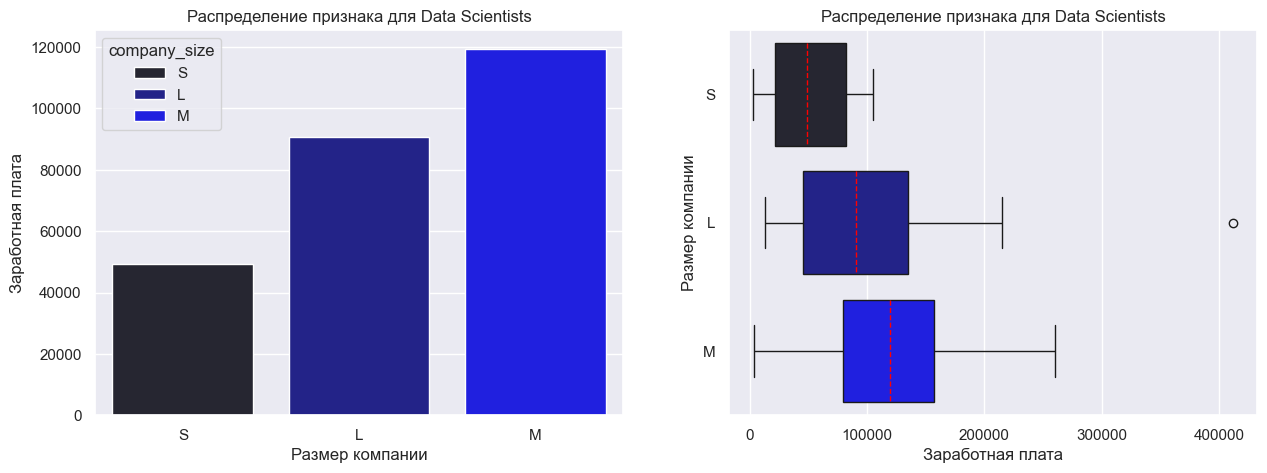

In [229]:
# Группируем зарплаты специалистов Data Science по размерам компаний и находим их медианное значение
ds_salaries_based_on_company_size = data_ds.groupby('company_size', as_index=False)['salary_in_usd'].median().sort_values('salary_in_usd')

fig, axes = plt.subplots(1, 2, figsize=(15 ,5))

# Столбчатая диаграмма зависимости медианы признака от размера компании для Data Scientists
sns.barplot(
    data=ds_salaries_based_on_company_size,
    x='company_size',
    y='salary_in_usd',
    hue='company_size',
    hue_order=ds_salaries_based_on_company_size['company_size'],
    order=ds_salaries_based_on_company_size['company_size'],
    palette='dark:blue',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Размер компании', ylabel = 'Заработная плата')
axes[0].set_title('Распределение признака для Data Scientists')

# Коробчатая диаграмма распределения признака по размеру компании для Data Scientists
sns.boxplot(
    data = data_ds,
    x='salary_in_usd',
    y='company_size',
    hue='company_size',
    hue_order=ds_salaries_based_on_company_size['company_size'],
    order=ds_salaries_based_on_company_size['company_size'],
    orient='h',
    palette='dark:blue',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel = 'Размер компании')
axes[1].set_title('Распределение признака для Data Scientists');

Выведем основную статистическую характеристику заработной платы для каждой категории размера компании. 

In [230]:
# Основная статистическая характеристика признака заработной платы для Data Scientists в разрезе размера компании
data_ds.groupby('company_size')['salary_in_usd'].describe().round()

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,43.0,102743.0,73254.0,13400.0,45240.0,90734.0,135000.0,412000.0
M,66.0,120081.0,56348.0,4000.0,80000.0,119530.0,157500.0,260000.0
S,21.0,51926.0,33216.0,2859.0,21669.0,49268.0,82500.0,105000.0


**Выводы по графику**

* Как мы можем видеть, медианы и распределения заработной платы в разрезе признака размера компании — `'company_size'` различны для каждой из групп. На первый взгляд можно сказать, что наблюдается связь уровня оплаты труда в профессии *Data Scientist* от размера компании.

  Выяснить так ли это нам поможет проведение статистических тестов над группами в следующем разделе нашего исследования.

* Категория `M` — средние по размеру компании имеют наибольшую медиану и самые длинные «усы» коробчатой диаграммы, что явно указывает на превосходство заработных плат над другими группами. Это не удивительно, ведь эта же группа имеет и самое выскокое количество наблюдений — 77.

  Категория же `L` — крупные компании, имеет выброс, что необходимо учитывать при проведении тестов над группами, чтобы получить точное подтверждение или опровержение сформулированной нами в будущем гипотезы.

### Наблюдается ли ежегодный рост зарплат у специалистов *Data Scientist*?

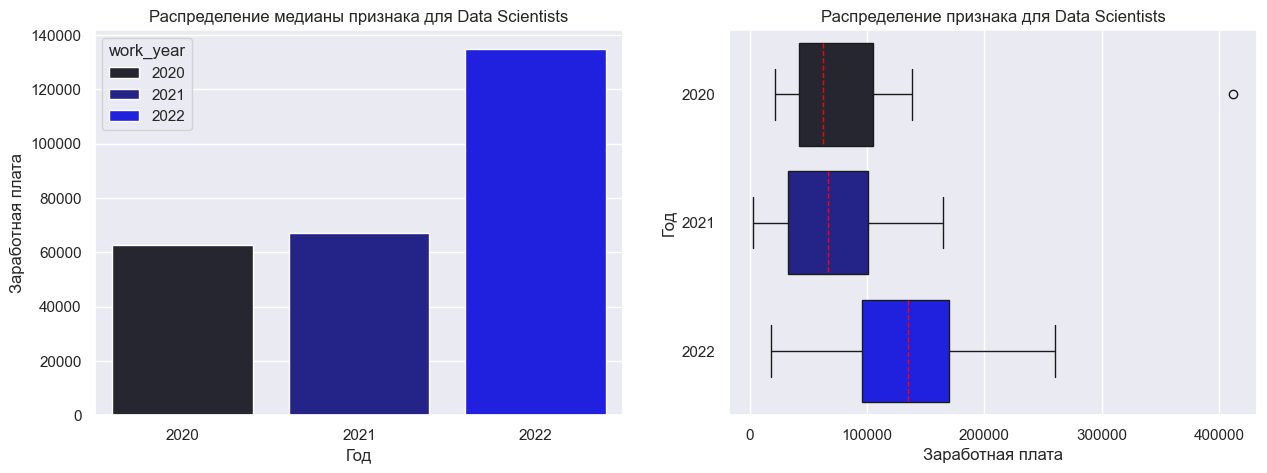

In [231]:
# Группируем зарплаты специалистов Data Science по годам и находим их медианное значение
ds_salaries_based_on_work_year = data_ds.groupby('work_year', as_index=False)['salary_in_usd'].median().sort_values('salary_in_usd')

fig, axes = plt.subplots(1, 2, figsize=(15 ,5))

# Столбчатая диаграмма зависимости медианы признака от года для Data Scientists
sns.barplot(
    data=ds_salaries_based_on_work_year,
    x='work_year',
    y='salary_in_usd',
    hue='work_year',
    hue_order=ds_salaries_based_on_work_year['work_year'],
    order=ds_salaries_based_on_work_year['work_year'],
    palette='dark:blue',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Год', ylabel = 'Заработная плата')
axes[0].set_title('Распределение медианы признака для Data Scientists')

# Коробчатая диаграмма распределения признака по году для Data Scientists
sns.boxplot(
    data = data_ds,
    x='salary_in_usd',
    y='work_year',
    orient='h',
    palette='dark:blue',
    legend=False,
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel = 'Год')
axes[1].set_title('Распределение признака для Data Scientists');

Выведем основную статистическую характеристику заработной платы для каждого года. 

In [232]:
# Основная статистическая характеристика признака заработной платы для Data Scientists в разрезе года
data_ds.groupby('work_year')['salary_in_usd'].describe().round()

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85971.0,81437.0,21669.0,42197.0,62726.0,105000.0,412000.0
2021,44.0,70216.0,45844.0,2859.0,32794.0,67234.0,100923.0,165000.0
2022,65.0,131367.0,55785.0,18442.0,95550.0,135000.0,170000.0,260000.0


**Выводы по графику**

* Учитывая медианы и сами распределения значений заработных плат для каждой из категорий может сложиться впечатление, что наблюдается явный ежегодный рост зарплат у *Data Scientists*.

  Но если обратить внимание на коробчатую диаграмму, а именно на то, в каком диапазоне находится наибольшее количество наблюдений значений для 2020 года по сравнению с 2021 — а оно больше, то явный ежегодный рост кажется уже не таким-то и явным, а вообще отсутвующим.

  Но помимо вышесказанного необходимо иметь в виду и то, что общее количество наблюдений для 2020 года в два раза меньше, по сравнению с 2021, что так же играет роль в распределении на графике.

* Для того чтобы выяснить это наверняка мы проведём ряд тестов над каждой из групп учитывая имеющийся у нас выброс в 2020 году.

### Как соотносятся зарплаты *Data Scientist* и *Data Engineer* в 2022 году?

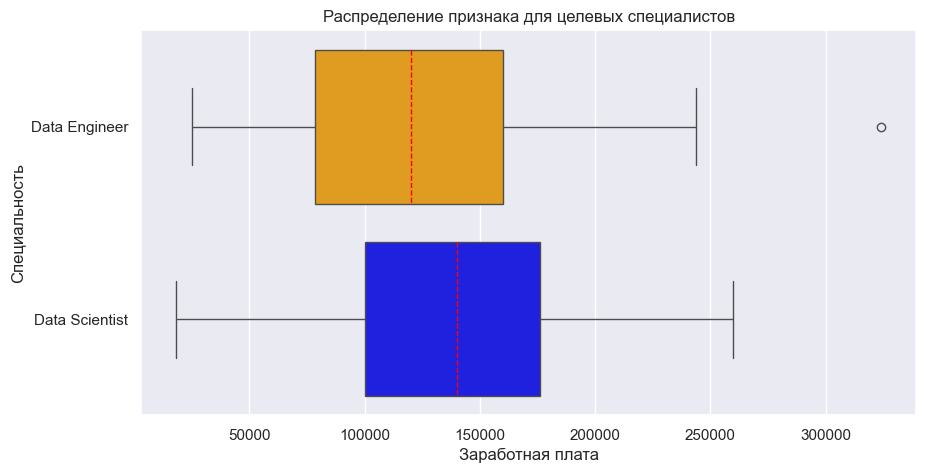

In [233]:
# Выбираем из временного массива интересующие нас записи
salaries_2022 = temporary_df.loc[(temporary_df['work_year'] == 2022) & (temporary_df['job_title'] == 'Data Scientist') | (temporary_df['work_year'] == 2022) & (temporary_df['job_title'] == 'Data Engineer')]

fig = plt.figure(figsize=(10, 5))

# Коробчатая диаграмма распределения признака по профессиям Data Scientists и Data Engineers
boxplot = sns.boxplot(
    data = salaries_2022,
    x='salary_in_usd',
    y='job_title',
    palette=['orange', 'blue'],
    orient='h',
    medianprops={'color': 'red', 'linestyle': '--'}
)
boxplot.set(xlabel='Заработная плата', ylabel = 'Специальность')
boxplot.set_title('Распределение признака для целевых специалистов');

Выведем основную статистическую характеристику заработной платы для каждой из целевой специальностей за 2022 год. 

In [234]:
# Основная статистическая характеристика признака заработной платы для Data Scientists и Data Engineers за 2022 год
salaries_2022.groupby('job_title')['salary_in_usd'].describe().round()

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,89.0,126376.0,55954.0,25000.0,78526.0,120000.0,160000.0,324000.0
Data Scientist,77.0,136172.0,54563.0,18442.0,100000.0,140000.0,176000.0,260000.0


**Выводы по графику**

* Не смотря на то, что мы наблюдали большие значения заработных плат у специалистов *Data Engineers* по сравнению с *Data Scientists* при визульном анализе распределения признака `'salary_in_usd'`, в 2022 году заметно превосходство именно группы `Data Scientist` над `Data Engineer` при меньшем количестве наблюдений для первой группы.

  Это заключение «имеет место быть» так же и потому, что для специалистов *Data Scientists* не наблюдается выбросов в значениях для 2022 года, в отличие от *Data Engineers*, что позволяет нам доверять среднему значению в 136172 *USD*.

* Если же посмотреть на распределение значений признака для группы `Data Engineer`, то заметно более высокое значение нижней границы «зарплатной вилки» — 25000 *USD* против 18442 *USD* у группы `Data Scientist`. При проведении необходимых для конечного вывода статистических тестов эта особенность может повлиять на итоговый результат теста. Границы же верхней «зарплатной вилки» остаются за *Data Scientists*

### Есть ли связь между наличием должностей *Data Scientist* и *Data Engineer* и размером компании?

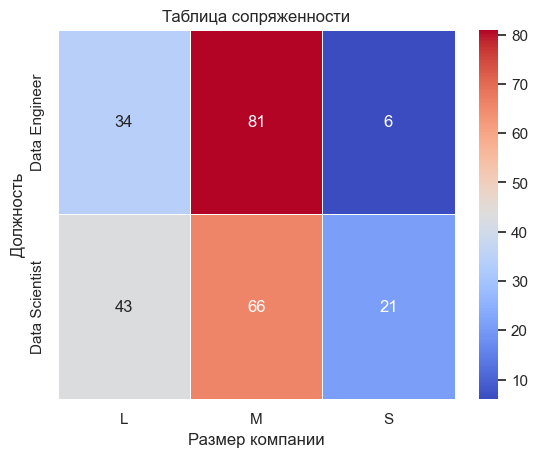

In [235]:
# Выбираем из наших данных интересующие нас записи
cross_tab_data = data.loc[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]

# Строим таблицу сопряженности
cross_tab = pd.crosstab(index=cross_tab_data['job_title'], columns=cross_tab_data['company_size'])

# Визуализируем таблицу сопряженности
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Должность')
ax.set_title('Таблица сопряженности');

**Выводы по графику**

* Согласно полученной нами таблице сопряженности, в компаниях большего размера (категории `M` и `L`) наблюдается большее количество сотрудников *Data Scientist* и *Data Engineer*, что в свою очередь говорит о возможном наличие связи признака `'company_size'` (признак размера компании) и количеством должностей для целевых профессий.

  Выяснить так ли это мы сможем при проведении статистических тестов над группами.

### Общий вывод по разведывательному анализу данных 

Благодаря более детальному анализу и визуализации признаков и их взаимосвязи между собой мы уже можем дать первичные ответы на интересующие нас вопросы:

 * Следующие признаки на первый взгляд имеют влияние на уровень оплаты труда специалистов *Data Scientists*:

   * `'experience_level'` — признак с категориями опыта работы специалистов;

   * `'employee_residence'` — признак с категориями стран в которых сотрудник проживал в течении рабочего года;

   * `'remote_ratio'` — признак с категориями объёма работы, выполняемого сотрудником удалённо;

   * `'company_location'` — признак с категориями стран в которых находится главный офис или филиал компании;

   * `'company_location'` — признак с категориями размеров компаний.

 * Согласно полученным данным о заработных платах специалистов *Data Scientists* с 2020 по 2022 года, мы не может быть уверены в явном ежегодном росте показателей, поскольку для 2020 года наблюдается превосходство диапазона нахождения большего числа записей по сравнению с 2021 при меньшем общем количестве записей.

 * В 2022 году заметно превосходство зарплат группы `Data Scientist` над `Data Engineer` согласно визуализации данных, при меньшем количестве наблюдений для первой группы.

 * При полученных в ходе визуального анализа влияния признаков на заработную плату специалистов *Data Scietists* данных мы можем прийти к выводу, что зарплаты в компаниях средних размеров (категория `'M'`) имеют доминирующие над остальными категориями показатели, имея при этом и наибольшее количество записей, что могло повлиять на распределение.

 * Основываясь на нашей таблице сопряженности, в компаниях большего размера (категории `M` и `L`) наблюдается большее количество сотрудников *Data Scientist* и *Data Engineer*, что может быть признаком связи размера компании и количеством должностей для целевых профессий.

Для того чтобы окончательно подтвердить или наоборот иметь основания опровергнуть наши первоначально сделанные выводы мы посветим следующий этап статистическому анализу данных — проведению статистических тестов над группами категорий признаков.

## Статистический анализ данных

In [236]:
# Задаём уровень значимости
alpha = 0.05 

# Функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# Функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### Какие факторы влияют на зарплату специалиста *Data Scientist*? 

#### Влияет ли опыт работы специалиста на размер его заработной платы?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы не отличается для разного опыта работы: Junior ($μ_1$), Intermediate ($μ_2$), Expert ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: размер заработной платы отличается для разного опыта работы: Junior ($μ_1$), Intermediate ($μ_2$), Expert ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [237]:
# Значения заработной платы для Junior
ds_salaries_en = data_ds.loc[data_ds['experience_level']=='EN', 'salary_in_usd']

# Значения заработной платы для Intermediate
ds_salaries_mi = data_ds.loc[data_ds['experience_level']=='MI', 'salary_in_usd']

# Значения заработной платы для Expert
ds_salaries_se = data_ds.loc[data_ds['experience_level']=='SE', 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для Junior:')
result = stats.shapiro(ds_salaries_en)
decision_normality(result[1])
print('')

print('Для Intermediate:')
result = stats.shapiro(ds_salaries_mi)
decision_normality(result[1])
print('')

print('Для Expert:')
result = stats.shapiro(ds_salaries_se)
decision_normality(result[1])

Для Junior:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Intermediate:
p-value = 0.146
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Expert:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Две группы из трёх (нет). 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [238]:
# Проводим тест
_, p = stats.kruskal(ds_salaries_en, ds_salaries_mi, ds_salaries_se)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть статистически значимая разница в размере заработной платы для разного опыта работы.

#### Размер заработной платы для специалистов проживающих США больше, чем в остальных странах?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы в США ($μ_1$) статистически меньше либо равен размеру заработной платы в других стран ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$):  размер заработной платы в США ($μ_1$) статистически больше, чем размер заработной платы в других стран ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [239]:
# Значения заработной платы для US
salaries_us = data_ds.loc[data_ds['employee_residence']=='US', 'salary_in_usd']

# Значения заработной платы для Other
salaries_other = data_ds.loc[data_ds['employee_residence']=='Other', 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для US:')
result = stats.shapiro(salaries_us)
decision_normality(result[1])
print('')

print('Для Other:')
result = stats.shapiro(salaries_other)
decision_normality(result[1])

Для US:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Other:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

In [240]:
# Проводим тест
_, p = stats.mannwhitneyu(salaries_us, salaries_other, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер заработной платы для специлистов проживающих в США статистически больше, чем в остальных странах.

#### Влияет ли общий объём работы, выполняемой сотрудником удалённо на размер его заработной платы?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы сотрудника не отличается для разного объёма работы, выполняемого удалённо: No ($μ_1$), Partially ($μ_2$), Full ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: размер заработной платы сотрудника отличается для разного объёма работы, выполняемого удалённо: No ($μ_1$), Partially ($μ_2$), Full ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [241]:
# Значения заработной платы для отсутствующей удалённой работы
salaries_no = data_ds.loc[data_ds['remote_ratio'] == 'No', 'salary_in_usd']

# Значения заработной платы для частично удалённой работы
salaries_partially = data_ds.loc[data_ds['remote_ratio'] == 'Partially', 'salary_in_usd']

# Значения заработной платы для полностью удалённой работы
salaries_full = data_ds.loc[data_ds['remote_ratio'] == 'Full', 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для No:')
result = stats.shapiro(salaries_no)
decision_normality(result[1])
print('')

print('Для Partially:')
result = stats.shapiro(salaries_partially)
decision_normality(result[1])
print('')

print('Для Full:')
result = stats.shapiro(salaries_full)
decision_normality(result[1])

Для No:
p-value = 0.331
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Partially:
p-value = 0.387
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Full:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Две группы из трёх (нет). 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [242]:
# Проводим тест
_, p = stats.kruskal(salaries_no, salaries_partially, salaries_full)
decision_hypothesis(p)

p-value = 0.020
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть статистически значимая разница в размере заработной платы специалиста с разным объёмом работы, выполняемым удалённо.

#### Размер заработной платы в компаниях, находящихся в США больше, чем в остальных странах?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы в компаниях, находящихся в США ($μ_1$) статистически меньше либо равен размеру заработной платы в компаниях, находящихся в других стран ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы в компаниях, находящихся в США ($μ_1$) статистически больше, чем размер заработной платы в компаниях, находящихся в других стран ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [243]:
# Значения заработной платы для US
salaries_us = data_ds.loc[data_ds['company_location'] == 'US', 'salary_in_usd']

# Значения заработной платы для Other
salaries_other = data_ds.loc[data_ds['company_location'] == 'Other', 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для US:')
result = stats.shapiro(salaries_us)
decision_normality(result[1])
print('')

print('Для Other:')
result = stats.shapiro(salaries_other)
decision_normality(result[1])

Для US:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Other:
p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

In [244]:
# Проводим тест
_, p = stats.mannwhitneyu(salaries_us, salaries_other, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер заработной платы в компаниях находящихся в США статистически больше, чем в остальных странах.

#### Влияет ли размер компании на размер заработной платы специалиста?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы сотрудника не отличается для разного размера компаний: S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: размер заработной платы сотрудника отличается для разного размера компаний: S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [245]:
# Значения заработной платы для компаний S-размера
salaries_s = data_ds.loc[data_ds['company_size'] == 'S', 'salary_in_usd']

# Значения заработной платы для компаний M-размера
salaries_m = data_ds.loc[data_ds['company_size'] == 'M', 'salary_in_usd']

# Значения заработной платы для компаний L-размера
salaries_l = data_ds.loc[data_ds['company_size'] == 'L', 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для S:')
result = stats.shapiro(salaries_s)
decision_normality(result[1])
print('')

print('Для M:')
result = stats.shapiro(salaries_m)
decision_normality(result[1])
print('')

print('Для L:')
result = stats.shapiro(salaries_l)
decision_normality(result[1])

Для S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для M:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Две группы их трёх (нет).

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [246]:
# Проводим тест
_, p = stats.kruskal(salaries_s, salaries_m, salaries_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Есть статистически значимая разница в размере заработной платы сотрудников в компаниях разных размеров.

Продолжаем наше исследование — выясним, как соотносятся зарплаты специалистов *Data Scientist* в компаниях различного размера?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы в компаниях M-размера ($μ_1$) статистически меньше либо равен размеру заработной платы в компаниях S-размера ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы в компаниях M-размера ($μ_1$) статистически больше, чем в компаниях S-размера ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да. 
* Дисперсии в двух группах равны? — Неизвестно.

Для проверки последнего критерия проведём тест Левена.

Для проверки нашей гипотезы можно использовать двухвыборочный t-критерий.

In [247]:
# Проводим тест Левена (тест на равенство дисперсий в группах)
print('Тест на равенство дисперсий')
result = stats.levene(salaries_m, salaries_s)
p = result[1]
print('p-value = {:.3f}'.format(p))

# Интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.018
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.


In [248]:
# Проводим тест
_, p = stats.ttest_ind(salaries_m, salaries_s, alternative='greater', equal_var=False)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Заработная плата сотрудников в компаниях M-размера статистически больше, чем в компаниях S-размера.

Продолжаем наше исследование — выясним, наблюдается ли рост зарплат специалистов *Data Scientist* в компаниях L-размера?

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Одна группа из двух (нет). 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

In [249]:
# Проводим тест
_, p = stats.mannwhitneyu(salaries_l, salaries_m, alternative='greater')
decision_hypothesis(p)

p-value = 0.976
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Промежуточный вывод**

Нет оснований утверждать, что заработная плата сотрудников в компаниях L-размера статистически больше, чем в компаниях M-размера.

Завершим наше исследование признака сравнением заработных плат в специалистов *Data Scientist* в компаниях L-размера и S-размера.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы в компаниях L-размера ($μ_1$) статистически меньше либо равен размеру заработной платы в компаниях S-размера ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы в компаниях L-размера ($μ_1$) статистически больше, чем в компаниях S-размера ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

Для проверки нашей гипотезы так же используем U-критерий Манна — Уитни.

In [250]:
# Проводим тест
_, p = stats.mannwhitneyu(salaries_l, salaries_s, alternative='greater')
decision_hypothesis(p)

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

В результате всех вышеприведенных статистических тестов, мы можем сделать следующие выводы касательно заработных плат сотрудников в компаниях различных размеров:

  1. Признак `'Размер компании'` имеет статистически значимое влияние на размер заработной платы специалиста.

  2. Размер заработной платы сотрудников имеет следющую градацию (от больших медианных значений к меньшим) в зависимости от размеров компании:

     * *M*-размер — 119529 USD

     * *L*-размер — 90734 USD

     * *S*-размер — 49268 USD

### Наблюдается ли ежегодный рост зарплат у специалистов *Data Scientist*?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы специалистов не отличается по годам: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: размер заработной платы специалистов отличается по годам: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [251]:
# Значения заработной платы для 2020 года
salaries_2020 = data_ds.loc[data_ds['work_year'] == 2020, 'salary_in_usd']

# Значения заработной платы для 2021 года
salaries_2021 = data_ds.loc[data_ds['work_year'] == 2021, 'salary_in_usd']

# Значения заработной платы для 2022 года
salaries_2022 = data_ds.loc[data_ds['work_year'] == 2022, 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для 2020:')
result = stats.shapiro(salaries_2020)
decision_normality(result[1])
print('')

print('Для 2021:')
result = stats.shapiro(salaries_2021)
decision_normality(result[1])
print('')

print('Для 2022:')
result = stats.shapiro(salaries_2022)
decision_normality(result[1])

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Две группы из трёх (нет). 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [252]:
# Проводим тест
_, p = stats.kruskal(salaries_2020, salaries_2021, salaries_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Есть статистически значимая разница в размере заработной платы сотрудников в разные года.

Продолжаем наше исследование — выясним, наблюдается ли ежегодный рост зарплат специалистов *Data Scientist*?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы в 2021 ($μ_1$) статистически меньше либо равен размеру заработной платы в 2020 ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы в 2021 ($μ_1$) статистически больше, чем в 2020 ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Одна группа из двух (нет). 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

In [253]:
# Проводим тест
_, p = stats.mannwhitneyu(salaries_2021, salaries_2020, alternative='greater')
decision_hypothesis(p)

p-value = 0.705
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Промежуточный вывод**

Нет оснований утверждать, что размер заработной платы в 2021 году статистически больше размера заработной платы в 2020 году.

Продолжаем наше исследование — выясним, наблюдается ли рост зарплат специалистов *Data Scientist* в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы в 2022 году ($μ_1$) статистически меньше либо равен размеру заработной платы в 2021 ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы в 2022 ($μ_1$) статистически больше, чем в 2021 ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.
* Дисперсии в двух группах равны? — Неизвестно.

Для проверки последнего критерия проведём тест Левена.

Для проверки нашей гипотезы можно использовать двухвыборочный t-критерий.

In [254]:
# Проводим тест Левена (тест на равенство дисперсий в группах)
print('Тест на равенство дисперсий')
result = stats.levene(salaries_2022, salaries_2021)
p = result[1]
print('p-value = {:.3f}'.format(p))

# Интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.264
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [255]:
# Проводим тест
_, p = stats.ttest_ind(salaries_2022, salaries_2021, alternative='greater', equal_var=True)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Размер заработной платы в 2022 году статистически больше, чем в 2021 году. Но больше ли он показателей 2020 года? Давайте это выясним.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы в 2022 году ($μ_1$) статистически меньше либо равен размеру заработной платы в 2020 ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы в 2022 ($μ_1$) статистически больше, чем в 2020 ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

Для проверки нашей гипотезы можно использовать всё тот же U-критерий Манна — Уитни.

In [256]:
# Проводим тест
_, p = stats.mannwhitneyu(salaries_2022, salaries_2020, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

После всех ранее проведённых статистических тестов над признаком, мы можем сделать следующие заключения:

  1. Размер заработной платы в 2022 году статистически больше, чем в 2020 и 2021 году.

  2. Размер заработной платы сотрудников имеет следющую градацию (от больших к меньшим), согласно статистическим тестам:

     * 2022 год

     * 2020 год

     * 2021 год
  
Соответственно, мы не можем смело утверждать об ежегодном росте зарплат специалистов *Data Scientist*, поскольку рост зарплат сотрудников наблюдается лишь для 2022 года по сравнению с 2020 и 2021.

### Как соотносятся зарплаты *Data Scientist* и *Data Engineer* в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы специалистов *Data Scientist* ($μ_1$) статистически меньше либо равен размеру заработной платы специалистов *Data Engineer* ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы специалистов *Data Scientist* ($μ_1$) статистически больше размера заработной платы специалистов *Data Engineer* ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [257]:
# Массив данных с информацией только о специалистах Data Engineer
data_de = data.loc[data['job_title'] == 'Data Engineer']

# Значения заработной платы для Data Scientists за 2022 год
salaries_de_2022 = data_de.loc[data_de['work_year'] == 2022, 'salary_in_usd']

# Значения заработной платы для Data Engineers за 2022 год
salaries_ds_2022 = data_ds.loc[data_ds['work_year'] == 2022, 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для Data Engineers:')
result = stats.shapiro(salaries_de_2022)
decision_normality(result[1])
print('')

print('Для Data Scientists:')
result = stats.shapiro(salaries_ds_2022)
decision_normality(result[1])

Для Data Engineers:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Data Scientists:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Одна группа из двух (нет).

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

In [258]:
# Проводим тест
_, p = stats.mannwhitneyu(salaries_ds_2022, salaries_de_2022, alternative='greater')
decision_hypothesis(p)

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

У нас нет оснований утверждать, что размер заработной платы для специалистов *Data Scientist* строго больше, чем у *Data Engineer*.

Но если обратить внимание на полученную нами вероятность допустить ошибку I рода (вероятность отклонить нулевую гипотезу, когда она верна), которая составляет 16% по сравнению с 84% в случае абсолютного превосходства зарплат специалистов *Data Engineer* над *Data Scientist*, то мы можем сделать вывод, что:
  
Распределения зарплат *Data Scientist* и *Data Engineer* в 2022 году различны, они имеют некоторые отклонениями в пользу *Data Scientist* и *Data Engineer* в частоте значений той или иной суммы заработной платы. Явного доминирования уровня оплаты труда специалистов одной гурппы над другой не наблюдается. 

Чтобы подкрепить сделанный нами вывод, визуализируем распределение показателей заработных плат специалистов за 2022 год. 

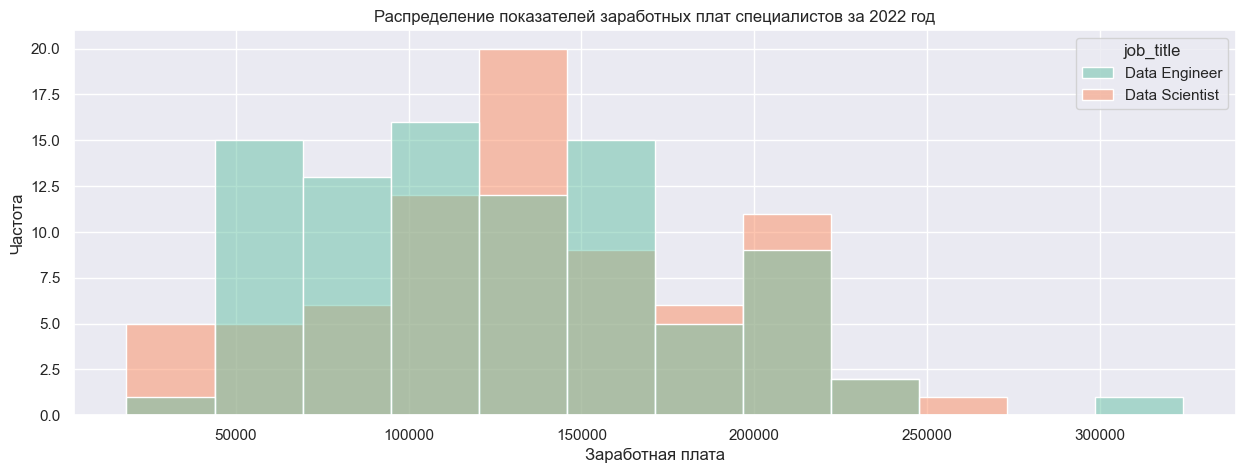

In [259]:
# Выьираем из нашего временного массива интересующие нас записи
salary_in_2022 = temporary_df.loc[(temporary_df['job_title'] == 'Data Scientist') & (temporary_df['work_year'] == 2022) | (temporary_df['job_title'] == 'Data Engineer') & (temporary_df['work_year'] == 2022)]

fig = plt.figure(figsize=(15,5))
histplot = sns.histplot(data=salary_in_2022, x='salary_in_usd', hue='job_title')
histplot.set(xlabel='Заработная плата', ylabel='Частота')
histplot.set_title('Распределение показателей заработных плат специалистов за 2022 год');

Как мы видим, наш ранее сделанный вывод подтвердился — 5 «столбцов превосходства» у *Data Scientist* против 5 у *Data Engineer*.

Но всё же, первенство в наивысшем мединном значении остаётся за специлаистами *Data Science* — 135000.0 USD против 115000.0 USD у *Data Engineer*

### Есть ли связь между наличием должностей *Data Scientist* и *Data Engineer* и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: связи между размером компании и количеством должностей для специалистов *Data Scientist* и *Data Engineer* нет (признаки независимы).

*Альтернативная гипотеза*: есть взаимосвязь между размером компании и количеством должностей для специалистов *Data Scientist* и *Data Engineer* (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Размер компании'`? — Категориальный.
* Сколько сравниваемых групп? — Три.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

In [260]:
# Вызываем нашу ранее созданную таблицу сопряжённости
cross_tab

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


In [261]:
# Проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между размером компании и количеством должностей для специалистов *Data Scientist* и *Data Engineer*.

## Дополнительные исследования

### Как соотносятся зарплаты специалистов *Data Scientist* и *Data Engineer* с разным опытом работы?

Для наглядного примера, сначала визуализируем распределение заработной платы и её медианы для *Data Scientists* и *Data Engineers* с разным опытом работы

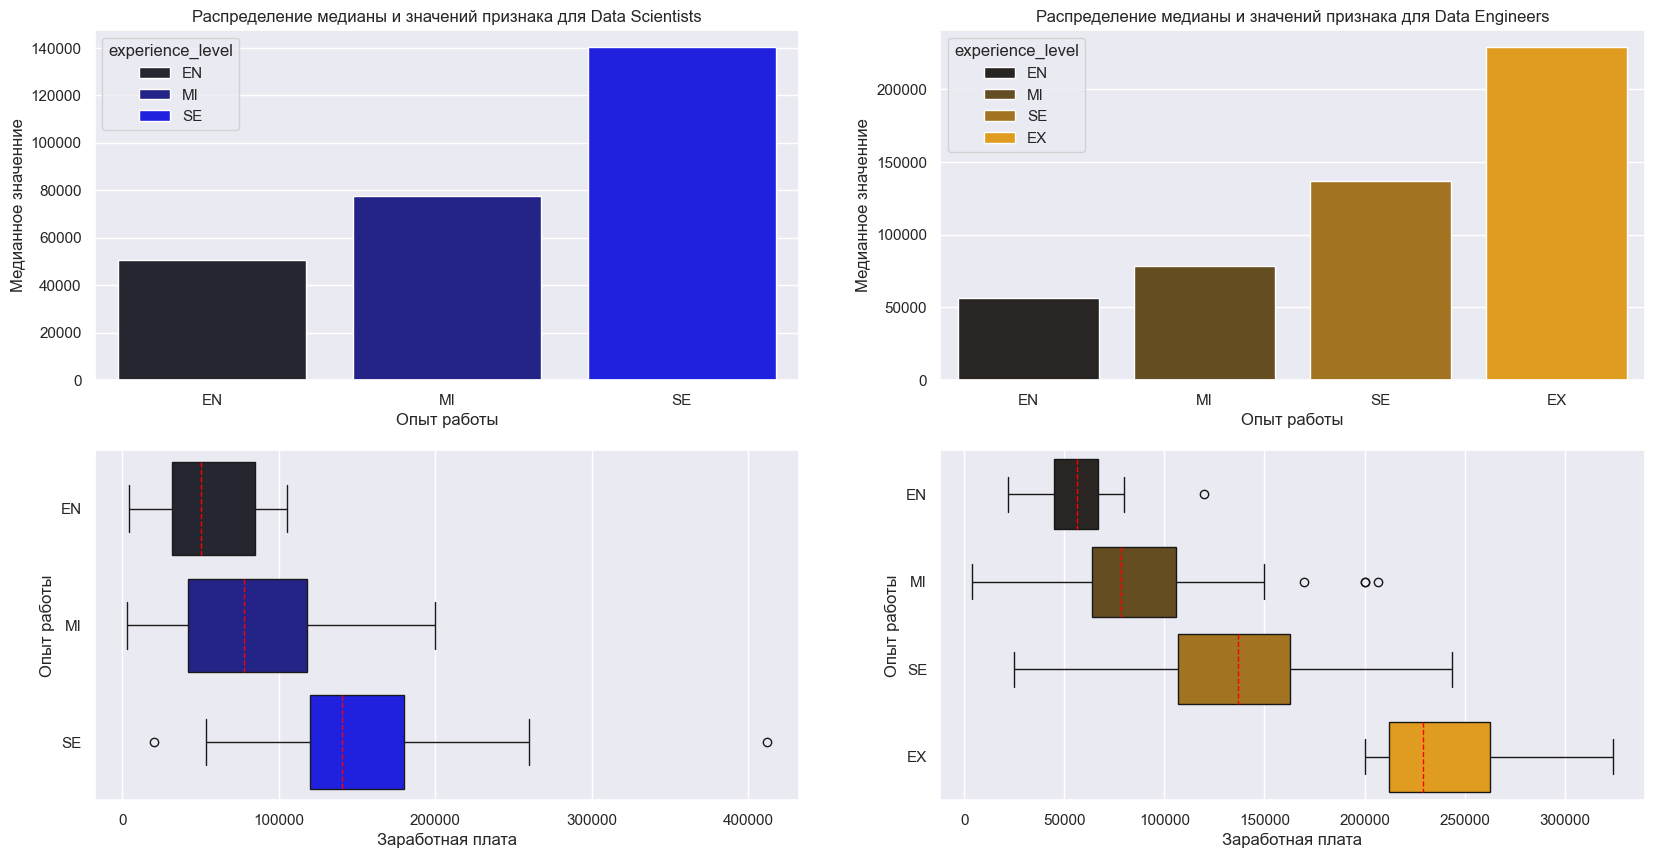

In [262]:
# Массив с данными для Data Scientists (сортировка данных необходима для корректной визуализации)
ds_temporary_df = temporary_df.loc[temporary_df['job_title'] == 'Data Scientist'].sort_values('experience_level')

# Массив со столбцами опыта рыботы и их медианными значениями для Data Scientists
median_ds_salaries_based_on_work_experience = ds_temporary_df.groupby('experience_level', as_index=False)['salary_in_usd'].median()

# Массив с данными для Data Engineers (сортировка данных необходима для корректной визуализации)
de_temporary_df = temporary_df.loc[temporary_df['job_title'] == 'Data Engineer'].sort_values('salary_in_usd')

# Массив со столбцами опыта рыботы и их медианными значениями для Data Engineers (сортировка данных необходима для корректной визуализации)
median_de_salaries_based_on_work_experience = de_temporary_df.groupby('experience_level', as_index=False)['salary_in_usd'].median().sort_values('salary_in_usd')

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Столбчатая диаграмма зависимости медианы признака от опыта работы для Data Scientists
sns.barplot(
    data=median_ds_salaries_based_on_work_experience,
    x='experience_level',
    y='salary_in_usd',
    hue='experience_level',
    palette='dark:blue',
    legend=True,
    ax=axes[0, 0]
)
axes[0, 0].set(xlabel='Опыт работы', ylabel = 'Медианное значенние')
axes[0, 0].set_title('Распределение медианы и значений признака для Data Scientists')

# Столбчатая диаграмма зависимости медианы признака от опыта работы для Data Engineers
sns.barplot(
    data=median_de_salaries_based_on_work_experience,
    x='experience_level',
    y='salary_in_usd',
    hue='experience_level',
    palette='dark:orange',
    legend=True,
    ax=axes[0, 1]
)
axes[0, 1].set(xlabel='Опыт работы', ylabel = 'Медианное значенние')
axes[0, 1].set_title('Распределение медианы и значений признака для Data Engineers')

# Коробчатая диаграмма распределения признака для Data Scientists
sns.boxplot(
    data=ds_temporary_df,
    x='salary_in_usd',
    y='experience_level',
    orient='h',
    palette='dark:blue',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1, 0]
)
axes[1, 0].set(xlabel='Заработная плата', ylabel='Опыт работы')

# Коробчатая диаграмма распределения признака для Data Engineers
sns.boxplot(
    data=de_temporary_df,
    x='salary_in_usd',
    y='experience_level',
    hue='experience_level',
    hue_order=median_de_salaries_based_on_work_experience['experience_level'],
    order=median_de_salaries_based_on_work_experience['experience_level'],
    orient='h',
    palette='dark:orange',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1, 1]
)
axes[1, 1].set(xlabel='Заработная плата', ylabel='Опыт работы');

**Выводы по графику**

На что здесь стоит обратить внимание?

Во-первых: как и в случае с специалистами *Data Scientists* у *Data Engineers* заметна разница в уровне зароботка в зависимости от опыта работы сотрудника.

Во-вторых: в отличие от *Data Scientists* у *Data Engineers* сотрудники с уровнем опыта `EN` (*Junior*) имеют более высокое начало «зарплатной вилки», чем их коллеги с уровнем опыта `MI` (*Intermediate*).

Сейчас сложно сказать наверняка, чем это может быть вызвано, но из предположений, мы можем выдвинуть следующие факторы:

  1. Год в котором работал сотрудник;

  2. Страна в которой находится компания, и в которой проживает сам сотрудник;

  3. Объём работы, который начинающему специалисту необходимо выполнять удалённо;

  4. Размер компании, в которой работает сотрудник.

Подтверждать или опровергать влияние данных факторов на заработную плату начинающих специалистов мы будём позже, сейчас же перейдём к формулировке гипотез касательно нашего вопроса и их проверке путём применения статистических тестов. 

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы не отличается для разного опыта работы у *Data Engineer*: *Junior* ($μ_1$), *Intermediate* ($μ_2$), *Expert* ($μ_3$), *Director* ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 $$

*Альтернативная гипотеза*: размер заработной платы отличается для разного опыта работы у *Data Engineer*: *Junior* ($μ_1$), *Intermediate* ($μ_2$), *Expert* ($μ_3$), *Director* ($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [263]:
# Значения заработной платы для Junior
de_salaries_en = data_de.loc[data_de['experience_level']=='EN', 'salary_in_usd']

# Значения заработной платы для Intermediate
de_salaries_mi = data_de.loc[data_de['experience_level']=='MI', 'salary_in_usd']

# Значения заработной платы для Expert
de_salaries_se = data_de.loc[data_de['experience_level']=='SE', 'salary_in_usd']

# Значения заработной платы для Director
de_salaries_ex = data_de.loc[data_de['experience_level']=='EX', 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для Junior:')
result = stats.shapiro(de_salaries_en)
decision_normality(result[1])
print('')

print('Для Intermediate:')
result = stats.shapiro(de_salaries_mi)
decision_normality(result[1])
print('')

print('Для Expert:')
result = stats.shapiro(de_salaries_se)
decision_normality(result[1])
print('')

print('Для Director:')
result = stats.shapiro(de_salaries_ex)
decision_normality(result[1])

Для Junior:
p-value = 0.443
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Intermediate:
p-value = 0.048
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Expert:
p-value = 0.952
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Director:
p-value = 0.337
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Три группы из четырёх (нет). 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [264]:
# Проводим тест
_, p = stats.kruskal(de_salaries_en, de_salaries_mi, de_salaries_se, de_salaries_ex)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Есть статистически значимая разница в размере заработной платы сотрудников *Data Engineer* с разным опытом работы.

Теперь, мы можем быть уверены, что как и у специалистов *Data Scientists* у *Data Engineers* есть статистически значимая разница в размере заработной платы с разным опытом работы.

Далее мы выясним для обоих специальностей какой опыт работы имеет наивысшую заработную плату, и как они соотносятся друг с другом?

Для удобства раздел с данным исследованием будет разделён на три части, согласно трём вопросам:

  1. Влияет ли карьерный рост (признак `'Опыт работы'`) специалистов *Data Scientist* на их заработную плату?

  2. Влияет ли карьерный рост (признак `'Опыт работы'`) специалистов *Data Engineer* на их заработную плату?

  3. Как соотносятся уровни заработной платы специалистов *Data Scientist* и *Data Engineer* с одинаковым опытом работы между собой?

#### Влияет ли карьерный рост специалистов *Data Scientist* на их заработную плату?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: среднее зачение заработной платы для сотрудников с опытом работы *Intermediate* ($μ_1$) статистически меньше либо равно среднему размеру заработной платы у *Junior* ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: среднее зачение заработной платы для сотрудников с опытом работы *Intermediate* ($μ_1$) статистически больше, чем среднее значение заработной платы у *Junior* ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

In [265]:
# Находим среднее значение заработной платы у Junior-специалистов
ds_salaries_en_mean = ds_salaries_en.mean()

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — Да.

Для проверки нашей гипотезы можно использовать одновыборочный t-критерий (*t-test*)

In [266]:
# Проводим тест
_, p = stats.ttest_1samp(ds_salaries_mi, popmean=ds_salaries_en_mean, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Средняя заработная плата специалистов с опытом `MI` (*Intermediate*) статистически больше, чем средняя зарпалта у `EN` (*Junior*).

Продолжаем наше исследование — выясним, является ли зарплата сотрудников с уровнем опыта `SE` (*Expert*) статистически больше, чем у `MI` (*Intermediate*)?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: среднее зачение заработной платы для сотрудников с опытом работы *Intermediate* ($μ_1$) статистически больше либо равно медианному значению заработной платы у *Expert* ($μ_2$).

$$ H_0 : μ_1 >= μ_2 $$

*Альтернативная гипотеза*: среднее зачение заработной платы для сотрудников с опытом работы *Intermediate* ($μ_1$) статистически меньше, чем  медианное значение заработной платы у *Expert* ($μ_2$).

$$ H_0 : μ_1 < μ_2 $$

Медианное значение было выбрано не просто так — как мы помним, при проведении теста на нормальность мы убедились в том, что распределение для группы `SE` (*Exeprt*) не является нормальным, следовательно, мы не можем применить к нему параметрические тесты. Но это не мешает нам сравнить группу с нормальным распределением (`MI`) с медианой, что меньше подвержена выбросам нашей группы *Exeprt*-специалистов.

In [267]:
# Находим медианное значение заработной платы у Expert-специалистов
ds_salaries_se_median = ds_salaries_se.median()

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — Да.

Для проверки нашей гипотезы можно использовать одновыборочный t-критерий (*t-test*)

In [268]:
# Проводим тест
_, p = stats.ttest_1samp(ds_salaries_mi, popmean=ds_salaries_se_median, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Средняя заработная плата специалистов с опытом `MI` (*Intermediate*) статистически меньше, чем медиана заработной платы у `SE` (*Expert*).

Соответственно, мы можем быть уверены, что уровень заработной платы *Data Scientist* прямо пропорционально зависит от признака карьерного роста сотрудника (`'Опыт работы'`).

#### Влияет ли карьерный рост специалистов *Data Engineer* на их заработную плату? 

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: среднее зачение заработной платы для сотрудников с опытом работы *Junior* ($μ_1$) статистически больше либо равно медиане заработной платы у *Intermediate* ($μ_2$).

$$ H_0 : μ_1 >= μ_2 $$

*Альтернативная гипотеза*: среднее зачение заработной платы для сотрудников с опытом работы *Junior* ($μ_1$) статистически меньше, чем медиана заработной платы у *Intermediate* ($μ_2$).

$$ H_0 : μ_1 < μ_2 $$

Как и в случае с *Data Scientist* медианное значение было выбрано не просто так — при проведении теста на нормальность у *Data Engineer* распределение для всех групп, кроме группы `MI` (*Intermediate*) является нормальным, следовательно, мы поступим так же как и до этого — мы будем сравать группы с нормальным распределением с медианой, что меньше подвержена выбросам нашей группы *Intermediate*-специалистов.

In [269]:
# Находим медианное значение заработной платы у Intermediate-специалистов
de_salaries_mi_median = de_salaries_mi.median()

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — Да.

Для проверки нашей гипотезы можно использовать одновыборочный t-критерий (*t-test*)

In [270]:
# Проводим тест
_, p = stats.ttest_1samp(de_salaries_en, popmean=de_salaries_mi_median, alternative='less')
decision_hypothesis(p)

p-value = 0.011
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Средняя заработная плата специалистов с опытом `EN` (*Junior*) всё же статистически меньше, чем медианное значение заработной платы у `MI` (*Intermediate*), несмотря на то, что у первой группы нижняя граница «зарплатной вилки» выше.

Продолжаем наше исследование — выясним, является ли зарплата сотрудников с уровнем опыта `SE` (*Expert*) статистически больше, чем у `MI` (*Intermediate*)?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: среднее зачение заработной платы для сотрудников с опытом работы *Expert* ($μ_1$) статистически меньше либо равно медиане заработной платы у *Intermediate* ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы для сотрудников с опытом работы *Expert* ($μ_1$) статистически больше, чем у *Intermediate* ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

Для проверки нашей гипотезы будет использовать уже хорошо нам знакомый одновыборочный t-критерий (*t-test*).

In [271]:
# Проводим тест
_, p = stats.ttest_1samp(de_salaries_se, popmean=de_salaries_mi_median, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Как и в предыдущем случае, средняя заработная плата специалистов с более высоким опытом (*Expert*) статистически больше, чем медиана у меньшего опыта (*Intermediate*).

Осталось выяснить, является ли зарплата директоров — `EX` (*Director*) статистически больше, чем у `SE` (*Expert*)?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: среднее значение заработной платы директоров — *Director* ($μ_1$) статистически меньше либо равен среднему значению заработной платы у *Expert* ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: среднее значение заработной платы директоров — *Director* ($μ_1$) статистически больше, чем у *Expert* ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

In [272]:
# Находим среднее значение заработной платы у Expert-специалистов
de_salaries_se_mean = de_salaries_se.mean()

Для проверки нашей гипотезы так же будет использовать одновыборочный t-критерий (*t-test*).

In [273]:
# Проводим тест
_, p = stats.ttest_1samp(de_salaries_ex, popmean=de_salaries_se_mean, alternative='greater')
decision_hypothesis(p)

p-value = 0.014
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Помимо очевидного преобладания среднего значения заработной платы директоров — `EX` (*Director*) над всеми остальными группами, мы выяснили, что как и в случае со специалистами *Data Scientists* у *Data Engineers* наблюдается повышение зарплат в зависимости от стажа сотрудника.

Теперь же, когда мы уверены в росте зарплат от признака стажа (`'Опыт работы'`) в обоих профессиях, мы можем сравнить их между собой, с один исключением — как мы помним, в наших данных нет упоминаний о специалистах *Data Science* со стажем `EX` (*Director*), а потому, мы будем сравнивать только те категории, где у нас имеются записи по обоим профессиям.

#### Как соотносятся уровни заработной платы специалистов *Data Scientist* и *Data Engineer* с одинаковым опытом работы между собой?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы для сотрудников *Data Scientist* с опытом работы *Junior* ($μ_1$) статистически меньше, либо равен размеру заработной платы для сотрудников *Data Engineer* с аналогичным опытом ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы для сотрудников *Data Scientist* с опытом работы *Junior* ($μ_1$) статистически больше, чем размер заработной платы для сотрудников *Data Engineer* с аналогичным опытом ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.
* Дисперсии в двух группах равны? — Неизвестно.

Для проверки последнего критерия проведём тест Левена.

Для проверки нашей гипотезы можно использовать двухвыборочный t-критерий.

In [274]:
# Проводим тест Левена (тест на равенство дисперсий в группах)
print('Тест на равенство дисперсий')
result = stats.levene(ds_salaries_en, de_salaries_en)
p = result[1]
print('p-value = {:.3f}'.format(p))

# Интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.262
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [275]:
# Проводим тест
_, p = stats.ttest_ind(ds_salaries_en, de_salaries_en, alternative='greater', equal_var=True)
decision_hypothesis(p)

p-value = 0.633
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Промежуточный вывод**

У нас нет оснований полагать, что заработная плата *Junior*-специалистов *Data Scientist* строго больше, чем у *Data Engineer*.

Если обратить внимание на вероятность допустить ошибку I рода (вероятность отклонить нулевую гипотезу, когда она верна), что составляет 63.3% по сравнению с 36.7% в случае абсолютного превосходства зарплат *Junior*-специалистов *Data Engineer* над *Data Scientist*, то станет очевидным, что «чаша весов» в данном случае наклонена больше в сторону *Data Engineer*, чем *Data Scientist*.

Продолжаем сравнивать группы — следующая на очереди группа *Intermediate* (`MI`).

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы для сотрудников *Data Scientist* с опытом работы *Intermediate* ($μ_1$) статистически меньше, либо равен размеру заработной платы для сотрудников *Data Engineer* с аналогичным опытом ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы для сотрудников *Data Scientist* с опытом работы *Intermediate* ($μ_1$) статистически больше, чем размер заработной платы для сотрудников *Data Engineer* с аналогичным опытом ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Одна группа из двух (нет).

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

In [276]:
# Проводим тест
_, p = stats.mannwhitneyu(ds_salaries_mi, de_salaries_mi, alternative='greater')
decision_hypothesis(p)

p-value = 0.610
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Промежуточный вывод**

У нас нет оснований полагать, что заработная плата *Intermediate*-специалистов *Data Scientist* строго больше, чем у *Data Engineer*.

Учитывая полученную вероятность допустить ошибку I рода (вероятность отклонить нулевую гипотезу, когда она верна), мы как и в случае с *Junior*-специалистами делаем вывод, что и в данном случае «чаша весов» наклонена больше в сторону *Data Engineer*.

Последней сравниваемой нами группой будут эксперты — *Expert* (`SE`).

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы для сотрудников *Data Scientist* с опытом работы *Expert* ($μ_1$) статистически меньше, либо равен размеру заработной платы для сотрудников *Data Engineer* с аналогичным опытом ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы для сотрудников *Data Scientist* с опытом работы *Expert* ($μ_1$) статистически больше, чем размер заработной платы для сотрудников *Data Engineer* с аналогичным опытом ($μ_2$).

$$ H_0 : μ_1 > μ_2 $$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Одна группа из двух (нет).

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

In [277]:
# Проводим тест
_, p = stats.mannwhitneyu(ds_salaries_se, de_salaries_se, alternative='greater')
decision_hypothesis(p)

p-value = 0.145
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Промежуточный вывод**

У нас нет оснований полагать, что заработная плата Expert-специалистов *Data Scientist* строго больше, чем у *Data Engineer*.

Но в случае с специалистами уровня Expert (`MI`) мы наблюдаем обратную ситуацию, по сравнению с *Junior*-специалистами и *Intermediate*-специалистами — согласно полученной вероятности допустить ошибку I рода (вероятность отклонить нулевую гипотезу, когда она верна) в 14.5% против 85.5% полного превосходства зарплат *Expert*-специалистов *Data Engineer* над *Data Scientist* явно заметно, что в этот раз «чаша весов» на стороне *Data Scientist*.

**Общий вывод по исследованию признака**

После всех исследований влияния признака `'Опыт работы'` на заработную плату специалистов профессий *Data Science* и *Data Engineering*, а так же их соотношения друг к другу, точно мы можем сказать лишь то, что для каждой из них заметна статистическая разница в зарплате в зависимости от стажа самого сотрудника. 

Абсолютного же лидера среди этих двух профессий не наблюдается. При аналогии с «чашой весов» мы убедились, что для каждой из этих двух специальностей наблюдается лишь отклонение в свою пользу, что не даёт нам полного основания утверждать об превосходстве уровня зарплат той или иной группы над другой.

### Какие признаки влияют на заработную плату начинающих специалистов *Data Scientist* и *Data Engineer*?

#### Влияние признака года на на заработную плату начинающих специалистов *Data Scientist* и *Data Engineer*

Для лучшего понимая того, как распределён признак `'Зарплата в долларах США'` в разных группах (по годам) мы его визуализируем.

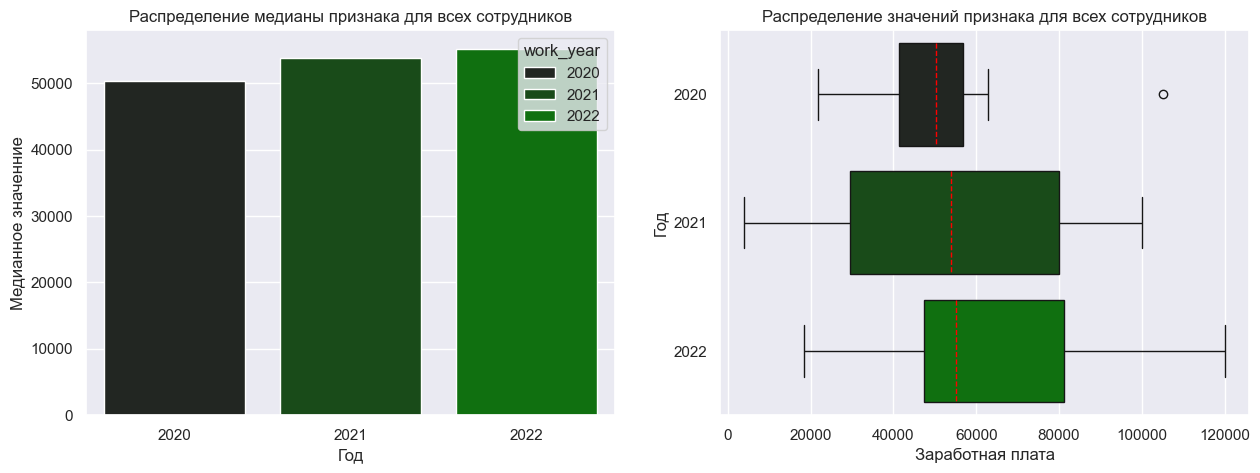

In [278]:
# Массив данных с информацией о начинающих специалистах Data Scientists и Data Engineers
junior_data = data.loc[(data['job_title'] == 'Data Scientist') & (data['experience_level'] == 'EN') | (data['job_title'] == 'Data Engineer') & (data['experience_level'] == 'EN')]

# DataFrame со столбцами года и их медианным значением заработной платы
median_junior_salaries_based_on_work_year = junior_data.groupby('work_year', as_index=False)['salary_in_usd'].median()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Столбчатая диаграмма зависимости медианы признака от года работы
sns.barplot(
    data=median_junior_salaries_based_on_work_year,
    x='work_year',
    y='salary_in_usd',
    hue='work_year',
    palette='dark:green',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Год', ylabel = 'Медианное значенние')
axes[0].set_title('Распределение медианы признака для всех сотрудников')

# Коробчатая диаграмма распределения значений признака от года работы
sns.boxplot(
    data=junior_data,
    x='salary_in_usd',
    y='work_year',
    orient='h',
    palette='dark:green',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel='Год')
axes[1].set_title('Распределение значений признака для всех сотрудников');

**Выводы по графику**

Как видно на графике, значения медианы и распределение признака для разных групп разное. Так же стоит обратить внимание на нижнюю границу заработной платы начинающих свою карьеру специалистов в 2020 году — она выше, чем в 2021 и 2022 году, но максимальные значения всё-таки ниже, по сравнению с 2021 и 2022 годом.

Являются ли эти различия статистически значимыми и наблюдается ли ежегодный рост зарплат *Junior*-специалистов помогут узнать статистические тесты.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: с каждым годом размер заработной платы *Junior* специалистов не изменяется: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: с каждым годом размер заработной платы *Junior* специалистов различен: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [279]:
# Значения заработной платы для 2020 года
junior_salaries_in_2020 = junior_data.loc[junior_data['work_year'] == 2020, 'salary_in_usd']

# Значения заработной платы для 2021 года
junior_salaries_in_2021 = junior_data.loc[junior_data['work_year'] == 2021, 'salary_in_usd']

# Значения заработной платы для 2022 года
junior_salaries_in_2022 = junior_data.loc[junior_data['work_year'] == 2022, 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для 2020 года:')
result = stats.shapiro(junior_salaries_in_2020)
decision_normality(result[1])
print('')

print('Для 2021 года:')
result = stats.shapiro(junior_salaries_in_2021)
decision_normality(result[1])
print('')

print('Для 2022 года:')
result = stats.shapiro(junior_salaries_in_2022)
decision_normality(result[1])

Для 2020 года:
p-value = 0.186
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для 2021 года:
p-value = 0.386
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для 2022 года:
p-value = 0.692
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.
* Дисперсии в двух группах равны? — Неизвестно.

Для проверки последнего критерия проведём тест Левена.

In [280]:
# Проводим тест Левена (тест на равенство дисперсий в группах)
print('Тест на равенство дисперсий')
result = stats.levene(junior_salaries_in_2020, junior_salaries_in_2021, junior_salaries_in_2022)
p = result[1]
print('p-value = {:.3f}'.format(p))

# Интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')

Тест на равенство дисперсий
p-value = 0.306
Дисперсии одинаковы, мы можем использовать тест ANOVA


Дисперсии одинаковы — мы можем смело использовать Однофакторный дисперсионный анализ (*ANOVA*)

In [281]:
# Проводим тест
_, p = stats.f_oneway(junior_salaries_in_2020, junior_salaries_in_2021, junior_salaries_in_2022)
decision_hypothesis(p)

p-value = 0.654
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Несмотря на то, что на первый взгляд по графику распределение значений заработной платы специалистов по годам разное, у нас нет оснований утверждать, что в разные года есть разница в зарплатах *Junior*-специалистов.

#### Влияние признака страны проживания сотрудника на заработную плату начинающих специалистов *Data Scientist* и *Data Engineer*

Сравним медианное значение и распределение заработных плат сотрудников проживающих в США (категория `'US'`) и остальных странах (категория `'Other'`).

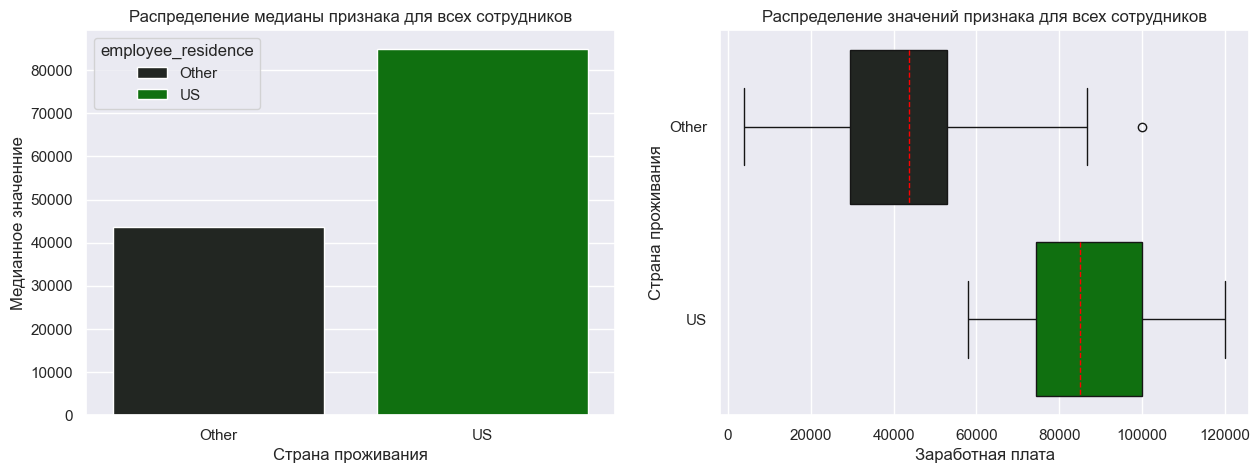

In [282]:
# DataFrame со столбцами страны проживания сотрудника и их медианным значением заработной платы
median_junior_salaries_based_on_employee_residence = junior_data.groupby('employee_residence', as_index=False)['salary_in_usd'].median()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Столбчатая диаграмма зависимости медианы признака от страны проживания сотрудника
sns.barplot(
    data=median_junior_salaries_based_on_employee_residence,
    x='employee_residence',
    y='salary_in_usd',
    hue='employee_residence',
    palette='dark:green',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Страна проживания', ylabel = 'Медианное значенние')
axes[0].set_title('Распределение медианы признака для всех сотрудников')

# Коробчатая диаграмма распределения значений признака от страны проживания сотрудника 
sns.boxplot(
    data=junior_data,
    x='salary_in_usd',
    y='employee_residence',
    orient='h',
    palette='dark:green',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel='Страна проживания')
axes[1].set_title('Распределение значений признака для всех сотрудников');

**Выводы по графику**

На графике заметно явное превосходство как в медиане, так и в распределениях значений признака заработной платы в зависимости от страны, в которой проживал сотрудник в течении рабочего года.

Чтобы узнать является ли размер заработной платы специалистов в США (`'US'`) статистически больше, чем в других странах (`'Other'`) проведём статистичсекие тесты.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы *Junior* специалистов проживающих в США ($μ_1$) статистически меньше, либо равен размеру заработной платы специалистов, проживающих в остальных странах ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы *Junior* специалистов проживающих в США ($μ_1$) статистически больше размера заработной платы специалистов, проживающих в остальных странах ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [283]:
# Значения заработной платы для US
junior_salaries_in_us = junior_data.loc[junior_data['employee_residence'] == 'US', 'salary_in_usd']

# Значения заработной платы для Other
junior_salaries_in_other = junior_data.loc[junior_data['employee_residence'] == 'Other', 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для US:')
result = stats.shapiro(junior_salaries_in_us)
decision_normality(result[1])
print('')

print('Для Other:')
result = stats.shapiro(junior_salaries_in_other)
decision_normality(result[1])

Для US:
p-value = 0.923
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Other:
p-value = 0.556
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.
* Дисперсии в двух группах равны? — Неизвестно.

Для проверки последнего критерия проведём тест Левена.

Для проверки нашей гипотезы можно использовать двухвыборочный t-критерий.

In [284]:
# Проводим тест Левена (тест на равенство дисперсий в группах)
print('Тест на равенство дисперсий')
result = stats.levene(junior_salaries_in_us, junior_salaries_in_other)
p = result[1]
print('p-value = {:.3f}'.format(p))

# Интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.871
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [285]:
# Проводим тест
_, p = stats.ttest_ind(junior_salaries_in_us, junior_salaries_in_other, alternative='greater', equal_var=True)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Мы можем быть уверены, что уровень заработной платы специалистов, проживающих в США статистически больше, по сравнению с сотрудниками, что проживают в других странах мира.

#### Влияние признака страны главного офиса компании на заработную плату начинающих специалистов *Data Scientist* и *Data Engineer*

Визуализируем медианы и распределения значений заработной платы разных групп для признака `'company_location'`.

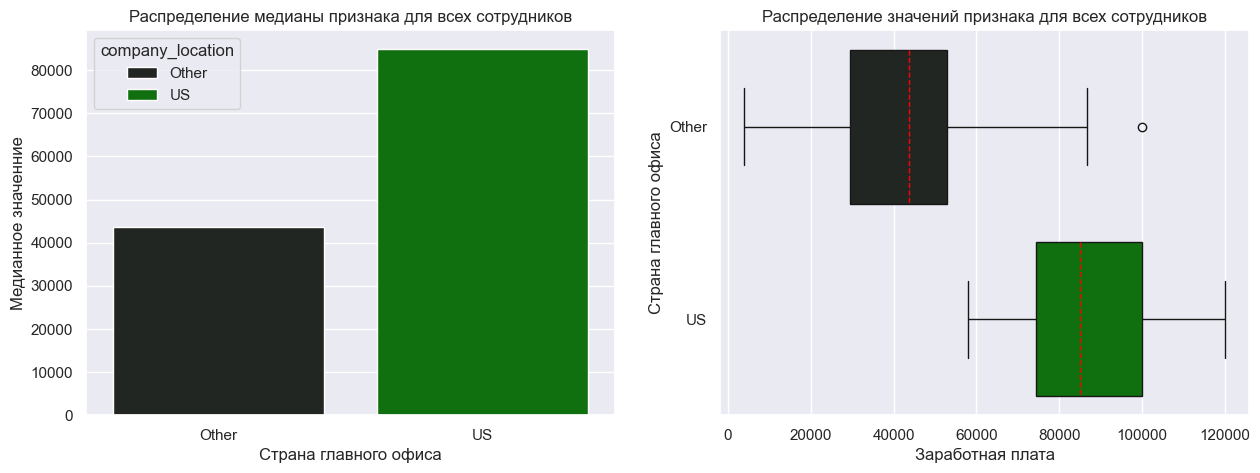

In [286]:
# DataFrame со столбцами страны главного офиса компании и их медианным значением заработной платы
median_junior_salaries_based_on_company_location = junior_data.groupby('company_location', as_index=False)['salary_in_usd'].median()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Столбчатая диаграмма зависимости медианы признака от страны главного офиса работодателя
sns.barplot(
    data=median_junior_salaries_based_on_company_location,
    x='company_location',
    y='salary_in_usd',
    hue='company_location',
    palette='dark:green',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Страна главного офиса', ylabel = 'Медианное значенние')
axes[0].set_title('Распределение медианы признака для всех сотрудников')

# Коробчатая диаграмма распределения значений признака от страны главного офиса работодателя
sns.boxplot(
    data=junior_data,
    x='salary_in_usd',
    y='company_location',
    orient='h',
    palette='dark:green',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel='Страна главного офиса')
axes[1].set_title('Распределение значений признака для всех сотрудников');

**Выводы по графику**

Как и в случае с предыдущим признаком, на первый взгляд кажется, что сотрудники работающие в компаниях, находящихся в США (`'US'`) зарабатывают заметно больше, чем в компаниях находящихся в других странах (`'Other'`).

Но вот что интересно — не кажется ли, что медианы и распределения значений в предыдущем признаке и этом одинаковы?

Сравним значения медиан для категорий признаков

In [287]:
# DataFrame со столбцами страны проживания сотрудника и их медианным значением заработной платы
median_junior_salaries_based_on_employee_residence

,employee_residence,salary_in_usd
0,Other,43748.0
1,US,85000.0


In [288]:
# DataFrame со столбцами страны главного офиса компании и их медианным значением заработной платы
median_junior_salaries_based_on_company_location

,company_location,salary_in_usd
0,Other,43748.0
1,US,85000.0


Сравним распределения значений для категорий признаков

In [289]:
# Значения заработных плат в компаниях, находящихся в US
junior_salaries_in_us_company = junior_data.loc[junior_data['company_location'] == 'US', 'salary_in_usd']

# Значения заработных плат в компаниях, находящихся в Other
junior_salaries_in_other_company = junior_data.loc[junior_data['company_location'] == 'Other', 'salary_in_usd']

# Сравниваем распределения значений групп в признаках employee_residence и company_location
print('Для US в признаках employee_residence и company_location:')
if list(junior_salaries_in_us) == list(junior_salaries_in_us_company):
    print('Значения заработных плат одинаковы')
else:
    print('Значения заработных плат не одинаковы')
print('')

print('Для Other в признаках employee_residence и company_location:')
if list(junior_salaries_in_other) == list(junior_salaries_in_other_company):
    print('Значения заработных плат одинаковы')
else:
    print('Значения заработных плат не одинаковы')

Для US в признаках employee_residence и company_location:
Значения заработных плат одинаковы

Для Other в признаках employee_residence и company_location:
Значения заработных плат одинаковы


Действительно, медианные значения и распределения в группах двух признаков одинаковы. Вероятнее всего, это связяно с тем, что сотрудники проживают в тех же странах, что и находится главный офис или филиал компании.

Тем не менее мы всё же проведём над группами данного признака статистические тесты, чтобы быть уверенными в выдвинутых выводах.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы *Junior* специалистов в компаниях находящихся в США ($μ_1$) статистически меньше, либо равен размеру заработной платы специалистов в компаниях находящихся в остальных странах ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы *Junior* специалистов в компаниях находящихся в США ($μ_1$) статистически больше размера заработной платы специалистов в компаниях находящихся в остальных странах ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [290]:
# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для US:')
result = stats.shapiro(junior_salaries_in_us_company)
decision_normality(result[1])
print('')

print('Для Other:')
result = stats.shapiro(junior_salaries_in_other_company)
decision_normality(result[1])

Для US:
p-value = 0.923
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Other:
p-value = 0.556
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.
* Дисперсии в двух группах равны? — Неизвестно.

Для проверки последнего критерия проведём тест Левена.

Для проверки нашей гипотезы можно использовать двухвыборочный t-критерий.

In [291]:
# Проводим тест Левена (тест на равенство дисперсий в группах)
print('Тест на равенство дисперсий')
result = stats.levene(junior_salaries_in_us_company, junior_salaries_in_other_company)
p = result[1]
print('p-value = {:.3f}'.format(p))

# Интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.871
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [292]:
# Проводим тест
_, p = stats.ttest_ind(junior_salaries_in_us_company, junior_salaries_in_other_company, alternative='greater', equal_var=True)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Как и ожидалось, сотрудники работающие в компаниях, находящихся в США зарабатывают статистически больше, чем в компаниях в других странах.

Но мы не можем быть уверены, что с имеющимися у нас данными, данный признак играет роли, ведь как мы убедились ранее, распределения значений заработной платы в разрезе данного признака аналогичны значениям, что мы наблюдали при работе с категориями стран, в которых проживали сотрудники в течении рабочего года.

#### Влияние объёма работы, выполняемого сотрудником удалённо на заработную плату начинающих специалистов *Data Scientist* и *Data Engineer*

Визуализируем распределение медианы и значений заработной платы в разрезе объёма работы, выполняемого *Junior*-специалистами удалённо.

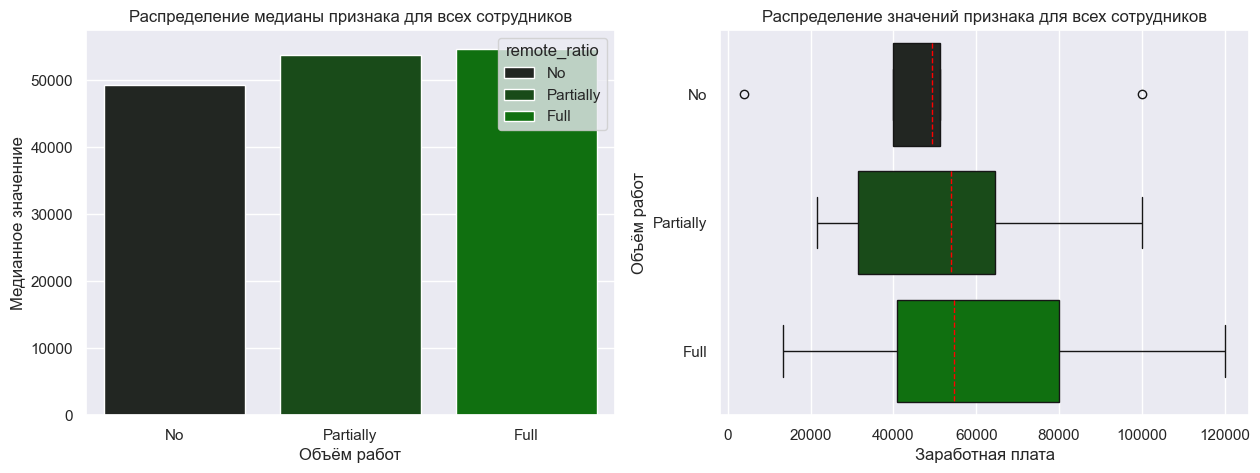

In [293]:
# DataFrame со столбцами объёма работы, выполняемого сотрудником удалённо и их медианным значением заработной платы
median_junior_salaries_based_on_remote_ratio = junior_data.groupby('remote_ratio', as_index=False)['salary_in_usd'].median().sort_values('salary_in_usd')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Столбчатая диаграмма зависимости медианы признака от объёма работы, выполняемого сотрудником удалённо
sns.barplot(
    data=median_junior_salaries_based_on_remote_ratio,
    x='remote_ratio',
    y='salary_in_usd',
    hue='remote_ratio',
    hue_order=median_junior_salaries_based_on_remote_ratio['remote_ratio'],
    order=median_junior_salaries_based_on_remote_ratio['remote_ratio'],
    palette='dark:green',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Объём работ', ylabel = 'Медианное значенние')
axes[0].set_title('Распределение медианы признака для всех сотрудников')

# Коробчатая диаграмма распределения значений признака от объёма работы, выполняемого сотрудником удалённо
sns.boxplot(
    data=junior_data,
    x='salary_in_usd',
    y='remote_ratio',
    hue='remote_ratio',
    hue_order=median_junior_salaries_based_on_remote_ratio['remote_ratio'],
    order=median_junior_salaries_based_on_remote_ratio['remote_ratio'],
    orient='h',
    palette='dark:green',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel='Объём работ')
axes[1].set_title('Распределение значений признака для всех сотрудников');

**Выводы по графику**

На первый взгляд медианные значения и сами распределения в разных категориях различны. Чтобы узнать, являются ли эти различия статистически значимыми необходимо провести статистические тесты над группами.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: с разным объёмом работ выполняемых сотрудником удалённо, размер заработной платы *Junior* специалистов не изменяется: *No* ($μ_1$), *Partially* ($μ_2$), *Full* ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: с разным объёмом работ выполняемых сотрудником удалённо, размер заработной платы *Junior* специалистов различен: *No* ($μ_1$), *Partially* ($μ_2$), *Full* ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [294]:
# Значения заработной платы без удалённой работы
junior_salaries_without_remote_work = junior_data.loc[junior_data['remote_ratio'] == 'No', 'salary_in_usd']

# Значения заработной платы с частично удалённой работой
junior_salaries_with_partial_remote_work = junior_data.loc[junior_data['remote_ratio'] == 'Partially', 'salary_in_usd']

# Значения заработной платы для полностью удалённой работы
junior_salaries_with_full_remote_work = junior_data.loc[junior_data['remote_ratio'] == 'Full', 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для No:')
result = stats.shapiro(junior_salaries_without_remote_work)
decision_normality(result[1])
print('')

print('Для Partially:')
result = stats.shapiro(junior_salaries_with_partial_remote_work)
decision_normality(result[1])
print('')

print('Для Full')
result = stats.shapiro(junior_salaries_with_full_remote_work)
decision_normality(result[1])

Для No:
p-value = 0.664
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Partially:
p-value = 0.534
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Full
p-value = 0.857
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.
* Дисперсии в двух группах равны? — Неизвестно.

Для проверки последнего критерия проведём тест Левена.

In [295]:
# Проводим тест Левена (тест на равенство дисперсий в группах)
print('Тест на равенство дисперсий')
result = stats.levene(junior_salaries_without_remote_work, junior_salaries_with_partial_remote_work, junior_salaries_with_full_remote_work)
p = result[1]
print('p-value = {:.3f}'.format(p))

# Интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')

Тест на равенство дисперсий
p-value = 0.941
Дисперсии одинаковы, мы можем использовать тест ANOVA


Дисперсии одинаковы — мы можем смело использовать Однофакторный дисперсионный анализ (*ANOVA*)

In [296]:
# Проводим тест
_, p = stats.f_oneway(junior_salaries_without_remote_work, junior_salaries_with_partial_remote_work, junior_salaries_with_full_remote_work)
decision_hypothesis(p)

p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

У нас нет оснований полагать, что есть разница в размере заработных плат для начинающих специалистов от объёма работы, выполняемого удалённо.

#### Влияние размера компании на заработную плату начинающих специалистов *Data Scientist* и *Data Engineer*

Сравним медианные значения и распределения признака заработной платы в разрезе признака `'company_size'`.

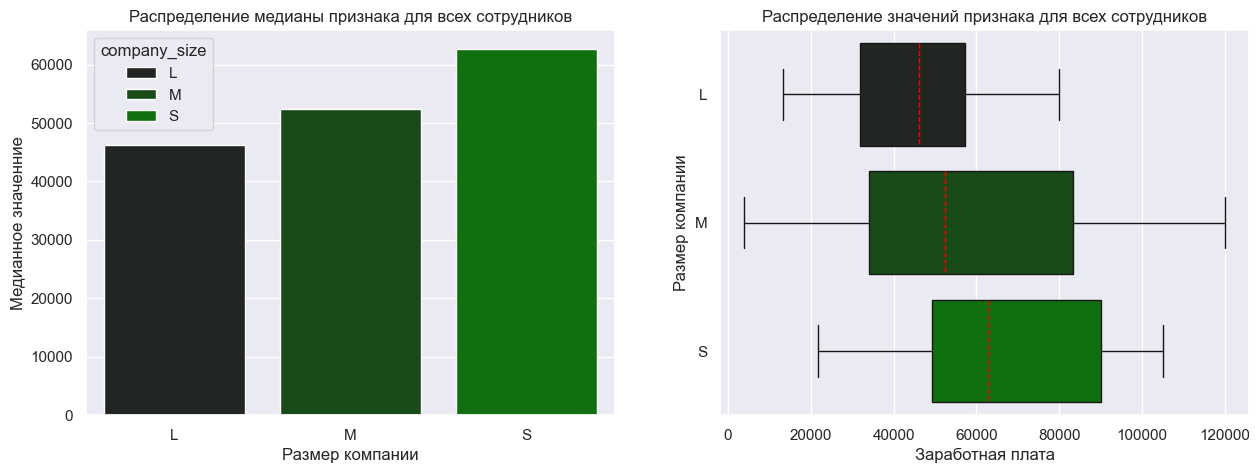

In [297]:
# DataFrame со столбцами размеров компаний и их медианным значением заработной платы
median_junior_salaries_based_on_company_size = junior_data.groupby('company_size', as_index=False)['salary_in_usd'].median().sort_values('salary_in_usd')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Столбчатая диаграмма зависимости медианы признака от размера компании
sns.barplot(
    data=median_junior_salaries_based_on_company_size,
    x='company_size',
    y='salary_in_usd',
    hue='company_size',
    palette='dark:green',
    legend=True,
    ax=axes[0]
)
axes[0].set(xlabel='Размер компании', ylabel = 'Медианное значенние')
axes[0].set_title('Распределение медианы признака для всех сотрудников')

# Коробчатая диаграмма распределения значений признака от размера компании
sns.boxplot(
    data=junior_data,
    x='salary_in_usd',
    y='company_size',
    orient='h',
    palette='dark:green',
    medianprops={'color': 'red', 'linestyle': '--'},
    ax=axes[1]
)
axes[1].set(xlabel='Заработная плата', ylabel='Размер компании')
axes[1].set_title('Распределение значений признака для всех сотрудников');

**Выводы по графику**

На графике заметно, что медианы и распределения значений признака для разных категорий различны. Есть явная необходимость в проведении статистических тестов над группами.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: в компаниях различных размеров, размер заработной платы *Junior* специалистов не изменяется: *S* ($μ_1$), *M* ($μ_2$), *L* ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: в компаниях различных размеров, размер заработной платы *Junior* специалистов различен: *S* ($μ_1$), *M* ($μ_2$), *L* ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально.

In [298]:
# Значения заработной платы в компаниях S-размеров
junior_salaries_in_s_company_size = junior_data.loc[junior_data['company_size'] == 'S', 'salary_in_usd']

# Значения заработной платы в компаниях M-размеров
junior_salaries_in_m_company_size = junior_data.loc[junior_data['company_size'] == 'M', 'salary_in_usd']

# Значения заработной платы в компаниях L-размеров
junior_salaries_in_l_company_size = junior_data.loc[junior_data['company_size'] == 'L', 'salary_in_usd']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для компаний S-размеров:')
result = stats.shapiro(junior_salaries_in_s_company_size)
decision_normality(result[1])
print('')

print('Для компаний M-размеров:')
result = stats.shapiro(junior_salaries_in_m_company_size)
decision_normality(result[1])
print('')

print('Для компаний L-размеров')
result = stats.shapiro(junior_salaries_in_l_company_size)
decision_normality(result[1])

Для компаний S-размеров:
p-value = 0.666
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для компаний M-размеров:
p-value = 0.892
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для компаний L-размеров
p-value = 0.929
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `'Зарплата в долларах США'`? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.
* Дисперсии в двух группах равны? — Неизвестно.

Для проверки последнего критерия проведём тест Левена.

In [299]:
# Проводим тест Левена (тест на равенство дисперсий в группах)
print('Тест на равенство дисперсий')
result = stats.levene(junior_salaries_in_s_company_size, junior_salaries_in_m_company_size, junior_salaries_in_l_company_size)
p = result[1]
print('p-value = {:.3f}'.format(p))

# Интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')

Тест на равенство дисперсий
p-value = 0.352
Дисперсии одинаковы, мы можем использовать тест ANOVA


Дисперсии одинаковы — мы можем смело использовать Однофакторный дисперсионный анализ (*ANOVA*)

In [300]:
# Проводим тест
_, p = stats.f_oneway(junior_salaries_in_s_company_size, junior_salaries_in_m_company_size, junior_salaries_in_l_company_size)
decision_hypothesis(p)

p-value = 0.385
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

У нас нет оснований считать, что есть разница в размере заработка *Junior*-специалистов в компаниях различных размеров.

### Выводы по дополнительным исследованиям

После всех исследований уровня зароботка специалистов *Data Science* и *Data Engineering* с разным опытом работы, их соотношением между собой, а так же влияния признаков на заработную плату *Junior*-специалистов мы убедились в том, что:

1. 
   * Есть статистически значимая разница в уровне зароботка специалистов *Data Scientist* и *Data Engineer* в зависимости от их опыта работы.

   * Лидера же среди этих двух профессий не наблюдается. В приведённой при исследовании аналогии с «чашой весов» мы убедились лишь в том, что для каждой из этих двух специальностей наблюдается отклонение в свою пользу в разных категориях опыта работы (`'experience_level'`), что не даёт нам полного права считать, что одна группа превосходит в уровне зарплат другую.

2. Из всех признаков, над которыми проводились исследования зарплат начинающих свою карьеру специалистов, статистически влияемыми на их размер были признаки `'employee_residence'` (признак страны, в которой проживает сотрудник) и `'company_location'` (признак страны главного офиса или филиала компании) — учитывая, что медианные значения и распределения в категориях этих двух признаков были одинаковы, мы не можем быть уверены наверняка, что при наличие большего количества записей для стран, что мы отметили как `'Other'` конечные результаты бы не отличались.  

## Финальный вывод по исследованию

Резюмируя всю проделанную работу над данными, мы можем быть уверены, что получили ответы на все поставленные *HR*-агенством вопросы, касающиеся рынка труда.

В качестве итога ещё раз вкратце оговорим полученные нами результаты статистических тестов над признаками:

* Cледующие факторы влияют на уровень заработной платы специалистов *Data Scientist*:

     * Год, в течении которого работал сотрудник (признак `'work_year'`);

     * Страна, в которой сотрудник проживал в течении рабочего года (признак `'employee_residence'`);

     * Объём работы, выполняемой сотрудником удалённо (признак `'remote_ratio'`);

     * Страна главного офиса или филиала компании (признак `'company_location'`);

     * Размер компании, в которой работал сотрудник (признак `'company_size'`).

* Ежегодный рост зарплат у специалистов *Data Scientist* не наблюдается — основываясь на имеющихся у нас данных рост уровня оплаты труда наблюдается лишь для 2022 года по сравнению с 2020 и 2021.

* Распределения зарплат специалистов *Data Scientist* и *Data Engineer* в 2022 году различны друг для друга. Абсолютного превосходства одной группы над другой не наблюдается.

* Согласно статистическим тестам, значения заработной платы специалистов *Data Scientist* в компаниях различных размеров имеют следующую градацию (от больших медианных значений к меньшим): 

  *M*-размер (119529 USD) > *L*-размер (90734 USD) > *S*-размер (49268 USD)

* Существует статистически значимая взаимосвязь между размером компании и количеством должностей для специалистов *Data Scientist* и *Data Engineer*.